### Master of Applied Artificial Intelligence

**Course: TC5035 - Proyecto Integrador**

<img src="../assets/logo.png" alt="Image Alt Text" width="500"/>


**Ingenieria de Caracteristicas**

Tutor: Dr. Horario Martinez Alfaro


Team members:
* Ignacio Jose Aguilar Garcia - A00819762
* Alejandro Calderon Aguilar - A01795353
* Ricardo Mar Cupido - A01795394


## Fundamento teórico y propiedad aditiva.
Los valores de Shapley reparten de forma “justa” la contribución de cada variable al resultado del modelo. En Machine Learning, SHAP define una línea base (valor esperado del modelo) y descompone la predicción individual como suma de contribuciones por feature; esa aditividad garantiza que la suma de aportes iguale la diferencia entre predicción y baseline, lo que habilita visualizaciones como waterfall plots y diagnósticos reproducibles.

<img src="../assets/Shap_Values.png" alt="Image Alt Text" width="500"/>

## Cómputo y lectura práctica.
En términos operativos, SHAP calcula, para cada observación, un vector de contribuciones cuyo agregado reproduce la predicción. En lineales, la intuición se ancla en diferencias respecto al valor esperado y puede visualizarse como una versión “centrada” de los PDPs; en árboles, TreeSHAP permite escalar a producción preservando exactitud. 

<img src="../assets/Ecuacion_Shap.png" alt="Image Alt Text" width="300"/>

# 0. Imports

In [1]:
!pip install category_encoders
!pip install shap
!pip install xgboost
!pip install imblearn
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install plotly
!pip install gdown

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
from tabulate import tabulate
from datetime import datetime
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import probplot

from category_encoders import OneHotEncoder
from category_encoders import TargetEncoder
#from category_encoders import OrdinalEncoder

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, confusion_matrix

from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
import shap

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import PolynomialFeatures
import gdown
import math

/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Funciones

In [3]:
class ExperimentalTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, feature_name, transformation = None, parameters = None):
        #print(f'Transformation: {transformation}, over feature: {feature_name}')
        self.feature_name = feature_name
        self.transformation = transformation
        self.parameters = parameters

    def fit(self, X, y=None):
        print("Doing fit on feature ",self.feature_name)
        X_ = X.copy()
        # ------------------
        # TARGET ENCODER
        # ------------------
        if (self.transformation == 'apply_target_encoder'):
            if (np.size(y) <= 0):
                raise Exception('Target Encoder requires "y" value')
            t_enc = self.apply_target_encoder(X_, y, self.feature_name)
            self.target_encoder = t_enc
        elif (self.transformation == 'use_target_encoder'):
            self.target_encoder = self.parameters['encoder']
        # ------------------
        # ONE HOT ENCODER
        # ------------------
        elif (self.transformation == 'apply_one_hot_encoder'):
            oh_enc = self.apply_one_hot_encoder(X_, self.feature_name)
            self.one_hot_encoder = oh_enc
        # ------------------
        # TRANSFORMER
        # ------------------
        elif (self.transformation == 'apply_transformer'):
            self.transformer = self.parameters['transformer']
        # ------------------
        # IMPUTE NAN VALUES
        # ------------------
        elif (self.transformation == 'impute_nan'): # it's stateless
            specific_value = None
            if (self.parameters != None and self.parameters['specific_value'] != None):
                specific_value = self.parameters['specific_value']
            self.impute_nan(X_, self.feature_name, self.parameters['metric'], specific_value, 'train')
        # ------------------
        # DELETE INVALID VALUES
        # ------------------
        elif (self.transformation == 'set_nan_value'): # it's stateless
            # self.set_nan_value(X_, self.feature_name, self.parameters['min'], self.parameters['min'])
            pass
        # ------------------
        # TRUNCATE COLUMN
        # ------------------
        elif (self.transformation == 'column_truncate'): # it's stateless
            # column_truncate(df_train, df_test, col_name, 1, 1)
            pass
        elif (self.transformation == 'clean_features'): # it's stateless
            pass
        return self

    def transform(self, X, y=None):
        print("Doing transform on feature ",self.feature_name)
        X_ = X.copy()
        if (self.transformation == 'apply_target_encoder'):
            X_[self.feature_name] = self.target_encoder.transform(X_[self.feature_name])
        elif (self.transformation == 'use_target_encoder'):
            X_[self.feature_name] = self.target_encoder.transform(X_[self.feature_name])
        elif (self.transformation == 'apply_one_hot_encoder'):
            X_ = self.one_hot_encoder.transform(X_)
        elif (self.transformation == 'apply_transformer'):
            X_[self.feature_name] = self.transformer.transform(X_[self.feature_name])
        elif (self.transformation == 'set_nan_value'):
            X_[self.feature_name] = self.set_nan_value(X_, self.feature_name, self.parameters['min'], self.parameters['max'])
        elif (self.transformation == 'impute_nan'):
            specific_value = None
            if (self.parameters != None and self.parameters['specific_value'] != None):
                specific_value = self.parameters['specific_value']
            X_[self.feature_name] = self.impute_nan(X_, self.feature_name, self.parameters['metric'], specific_value)
        elif (self.transformation == 'column_truncate'):
            X_[self.feature_name] = self.column_truncate(X_, self.feature_name, self.parameters['upper_bound'], self.parameters['value'])
        elif (self.transformation == 'clean_features'):
            X_ = X_[self.parameters['features']]
        return X_

    def set_nan_value(self, df_train, col_name, lower_bound, upper_bound):
        '''
        Setea null a los valores de la columna fuera de los limites de lower_bound y upper_bound
        '''
        print("Doing transform on feature ",col_name, " | lower bound:", lower_bound, " | upper bound:", upper_bound)
        train_col = df_train[col_name].mask(((df_train[col_name] < lower_bound) | (df_train[col_name] >= upper_bound)), np.nan)
        return train_col

    def apply_target_encoder(self, df_train, y, col_name):
        '''
        Aplica un encoder de target contra churn y devuelve las columans para train
        y test
        '''
        t_enc = TargetEncoder()
        t_enc.fit(df_train[col_name],y)
        return t_enc

    def apply_one_hot_encoder(self, df_train, col_name):
        '''
        Aplica un one hot encoder y devuelve las columans para train
        y test
        '''
        clsfctn_enc = OneHotEncoder(use_cat_names=True,cols=[col_name])
        # se excluyen los nan para evitar que cree una columna para ellos
        clsfctn_enc.fit(df_train.dropna(subset=[col_name], inplace=False))
        return clsfctn_enc

    def impute_nan(self, df_train, col_name, metric='median',specific_value=None, state='test'):
        '''
        Imputa los valores nulos de la columna utilizando diferentes estrategias:
        * metric = 'median'
        * metric = 'mean'
        * metric = 'specific' con valor definido en specific_value
        '''
        if (state != 'test'):
            if metric=='median':
                self.impute_nan_value = df_train[col_name].median()
            elif metric == 'mean':
                self.impute_nan_value = df_train[col_name].mean()
            elif metric == 'specific':
                self.impute_nan_value = specific_value
            else:
                self.impute_nan_value = specific_value

        print("","The value on impute_nan is:", self.impute_nan_value)
        train_col = df_train[col_name].fillna(self.impute_nan_value, inplace=False)
        return train_col

    def column_truncate(self, df_train, col_name, upper_bound, value=None):
        '''
        Trunca el valor de una columna en cierto valor (upper_bound) y le coloca el valor (si es nulo utiliza el upper_bound)
        '''
        train_col = df_train[col_name].mask((df_train[col_name] >= upper_bound), value if value!=None else upper_bound)
        return train_col

In [4]:
class Debug(BaseEstimator, TransformerMixin):
    def transform(self, X):
        print(X.shape)
        X.to_csv("x.csv", index=False)
        # what other output you want
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [5]:
def df_split(df):
    df_X = df.drop('sale',axis=1)
    df_y = df['sale']
    return df_X, df_y

In [6]:
def under_sampling(X, y, ratio, random_state=123):
    under = RandomUnderSampler(random_state=random_state, sampling_strategy=ratio)
    return under.fit_resample(X, y)

In [7]:
def threshold_truncate(y, scores, threshold):
  prediction = (scores >= threshold).astype(int)
  precision, recall, f1, o = precision_recall_fscore_support(y, prediction, average='binary', labels=[1,0])
  tn, fp, fn, tp = confusion_matrix(y, prediction).ravel()
  result = {
      'threshold': threshold
      #, 'prediction': prediction
      , 'positive_prediction': prediction.mean()
      , 'precision': precision
      , 'recall': recall
      , 'f1': f1
      , 'support': o
      , 'tn': tn
      , 'fp': fp
      , 'fn': fn
      , 'tp': tp
  }
  return result

In [8]:
def threshold_iter(y, scores, min=0, max=1, step=0.1):
  if (min < 0):
    min = 0.0
  if (max > 1):
    max = 1.0
  if (not (min < step and step < max)):
    step = 0.1

  results = []
  for threshold in np.arange(min, max, step):
    result = threshold_truncate(y, scores, threshold)
    results.append(result)
  return results

In [9]:
def plot_threshold_metrics(df):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
    fig.suptitle('Model metrics per threshold: ', fontsize=18)

    # Precision
    df.plot(x='threshold', y=['precision'], ax=axes[0])
    axes[0].set_title('Precision')

    # Precision
    df.plot(x='threshold', y=['recall'], ax=axes[1])
    axes[1].set_title('Recall')

    # Precision
    df.plot(x='threshold', y=['f1'], ax=axes[2])
    axes[2].set_title('F1')

    plt.tight_layout()

In [10]:
def evaluate_shap_values(model, X_test, plot=False):
    # Fits the explainer
    explainer = shap.Explainer(model)
    # Calculates the SHAP values - It takes some time
    shap_values = explainer(X_test)
    if plot:
        shap.plots.bar(shap_values)
        shap.summary_plot(shap_values)
    return shap_values

In [11]:
def plot_hist_prob(df, col_name, plot_transforms=True):
    if plot_transforms==False:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,3))

        # Histogram & Density
        sns.histplot(data=df, x=col_name, ax=axes[0], kde=True)
        axes[0].set_title('Histogram')

        # Probability Plot
        probplot(df[col_name], plot=axes[1])
        #axes[1].set_title(axes[1].get_title()+' Quantile Transformed data')

        # boxplot
        sns.boxplot(data=df, x=col_name, ax=axes[2], showfliers = True)
        axes[2].set_title('Boxplot')

        plt.tight_layout()
    else:
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,9))
        fig.suptitle(col_name, fontsize=18)

        # Histogram & Density
        sns.histplot(data=df, x=col_name, ax=axes[0,0], kde=True)
        axes[0,0].set_title('Histogram')

        # Probability Plot
        probplot(df[col_name], plot=axes[0,1])

        # boxplot
        sns.boxplot(data=df, x=col_name, ax=axes[0,2], showfliers = True)
        axes[0,2].set_title('Boxplot')

        df_tmp = df.copy()
        # -------------------------------
        # QUANTILE
        # -------------------------------
        q_transformer = QuantileTransformer(output_distribution='normal')
        q_transformer.fit(df_tmp[[col_name]])

        df_tmp['q_'+col_name] = q_transformer.transform(df_tmp[[col_name]])

        # Histogram & Density
        sns.histplot(data=df_tmp, x='q_'+col_name, ax=axes[1,0], kde=True)
        axes[1,0].set_title('Histogram')

        # Probability Plot
        probplot(df_tmp['q_'+col_name], plot=axes[1,1])

        # boxplot
        sns.boxplot(data=df_tmp, x='q_'+col_name, ax=axes[1,2], showfliers = True)
        axes[1,2].set_title('Boxplot')

        # -------------------------------
        # YEO JONSHON
        # -------------------------------
        yj_transformer = PowerTransformer(method='yeo-johnson')
        yj_transformer.fit(df_tmp[[col_name]])

        df_tmp['yj_'+col_name] = yj_transformer.transform(df_tmp[[col_name]])

        # Histogram & Density
        sns.histplot(data=df_tmp, x='yj_'+col_name, ax=axes[2,0], kde=True)
        axes[2,0].set_title('Histogram')

        # Probability Plot
        probplot(df_tmp['yj_'+col_name], plot=axes[2,1])

        # boxplot
        sns.boxplot(data=df_tmp, x='yj_'+col_name, ax=axes[2,2], showfliers = True)
        axes[2,2].set_title('Boxplot')


        plt.tight_layout()


# 2. Data Preparation

* **Ubicación y demografía**

  * **state_name** *(str)*: Customer’s department/state (e.g., GUATEMALA, JALAPA).
  * **state_city_equals** *(binary 0/1)*: Department and city match (address quality).
  * **client_gender** *(str: M/F/na)*: Declared gender.
  * **client_age** *(num)*: Age in years.


* **Historial de telemarketing / clasificación previa**

  * **previous_classification** *(str)*: Outcome of the prior outreach (NEW CLIENT, NOT INTERESTED, NOT EFFECTIVE, etc.).
  * **previous_calls** *(int)*: Number of previous calls.
  * **previous_not_effective_count** *(int)*: Prior “not effective” calls.
  * **previous_not_interested_count** *(int)*: Times the customer stated not interested.

* **Identificación y antigüedad en red**

  * **client_has_nit** *(binary)*: Has tax ID (1) or not (0).
  * **network_age_years** *(num)*: Tenure on the network (years).
  * **start_using_months** *(int)*: Months since first line usage.
  * **imei_first_use_months** *(int)*: Months since the IMEI first appeared on the network.
  * **imei_distinct_users** *(int)*: Number of distinct users for that IMEI.

* **Cartera de productos (RGUs) y plan**

  * **rgus_prepaid / rgus_postpaid / rgus_home** *(int)*: Active products by type.
  * **plan_postpaid** *(binary)*: Has an active postpaid plan (1/0).
  * **class** *(int)*: Internal device/customer segment/score (e.g., 3/4/5).
  * **socioeconomic_level** *(str: A–E, C-, C+, etc.)*: Estimated socioeconomic level.

* **Banca y afinidad financiera**

  * **banking** *(binary)*: Banked per internal/external sources.
  * **sn_banking** *(binary)*: Social/alternative banking signal.
  * **digital_tokenized_card** *(binary)*: Has a tokenized card in Tigo’s digital ecosystem.

* **Facturación, gasto y uso de red**

  * **arpu_90_days** *(num, currency)*: Average ARPU over the last 90 days.
  * **navegation_gb** *(num, GB)*: Total mobile data consumed.
  * **minutes_out / minutes_in** *(num, min)*: Outgoing/incoming minutes.
  * **percent_of_weeks_with_data_purchase** *(0–1)*: Share of weeks with a data purchase.
  * **purchase_average** *(num)*: Average top-up/purchase ticket.
  * **validity_average** *(num, days)*: Average validity of packages.
  * **average_performance** *(~0–1.5)*: Internal line activity index.
  * **with_international_calls** *(binary)*: Makes international calls.
  * **arpu_gte_100** *(binary)*: ARPU ≥ 100.
  * **navigation_gte_5gb** *(binary)*: Data usage ≥ 5 GB.

* **Tecnología y dispositivo**

  * **network_technology_code** *(str)*: Access technology (3G/4G/5G).
  * **operating_system** *(str)*: Device OS (ANDROID/iOS…).
  * **type_name** *(str)*: Device type (SMARTPHONE, FEATURE PHONE, etc.).
  * **brand_name / model_name** *(str)*: Device brand and model.

* **Gráfica social / agenda del cliente**

  * **contacts** *(int)*: Detected contacts.
  * **tigo_contacts** *(int)*: Contacts within Tigo’s network.
  * **high_frequency_contacts** *(decimal 0–1)*: Share/score of high-frequency contacts.

* **Comportamiento digital Tigo**

  * **digital_months** *(int)*: Months using Tigo digital channels.
  * **digital_index_mean** *(0–1)*: Average digital adoption score.
  * **connected_days / charged_days / apps_days / zero_rate_days** *(int)*: Days with connection, with charging, with app usage, and with zero-rating.

* **Uso por aplicación (engagement)**

  * **facebook_days / facebook_gb** *(int / GB)*: Days and GB on Facebook.
  * **tiktok_days / tiktok_gb** *(int / GB)*: Days and GB on TikTok.
  * **instagram_days / instagram_gb** *(int / GB)*: Days and GB on Instagram.
  * **whatsapp_days / whatsapp_gb** *(int / GB)*: Days and GB on WhatsApp.
  * **youtube_days / youtube_gb** *(int / GB)*: Days and GB on YouTube.
  * **music_days / music_gb** *(int / GB)*: Days and GB on music apps.

* **Señales derivadas y consistencia**

  * **state_city_equals** *(binary)*: (as above) validates address consistency.
  * **C+, C-, D, E** *(in `socioeconomic_level`)*: Ordinal coding for targeting.

* **Variable objetivo**

  * **sale** *(str: YES/NO)*: Sales/contact outcome (model target).


## 2.1 Download dataset

**Important: the following csv file is completly confidencial, it's not allowed to scam it**

In [12]:
!mkdir data
url = 'https://drive.google.com/uc?export=download&id=1rmHf8nMsml059APC6ftFytKjVlUnbOUp'
output = 'data/sale.csv'

mkdir: data: File exists


In [13]:
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1rmHf8nMsml059APC6ftFytKjVlUnbOUp
From (redirected): https://drive.google.com/uc?export=download&id=1rmHf8nMsml059APC6ftFytKjVlUnbOUp&confirm=t&uuid=dc807232-74ca-44fd-a656-175c8c76cc8b
To: /Users/ricardomarcupido/Documents/Maestria/proyecto_integrador/Proyecto-Integrador/data/sale.csv
100%|██████████| 299M/299M [01:16<00:00, 3.93MB/s] 


'data/sale.csv'

## 2.2 Read csv file into a pandas dataframe

In [14]:
df = pd.read_csv(output)

## 2.3 Dataframe shape

This line helps us to know how many rows our dataframe has

In [15]:
df.shape

(610083, 60)

## 2.4 Show the 5 first rows of dataset

We show the first 5 rows of dataset 

In [16]:
df.head()

state_name previous_classification  previous_calls  \
0         JALAPA              NEW CLIENT               0   
1      GUATEMALA              NEW CLIENT               0   
2   ALTA VERAPAZ          NOT INTERESTED               2   
3  CHIMALTENANGO          NOT INTERESTED               3   
4  HUEHUETENANGO          NOT INTERESTED               6   

   previous_not_effective_count  previous_not_interested_count client_gender  \
0                             0                              0             M   
1                             0                              0             F   
2                             1                              1             M   
3                             1                              2             M   
4                             4                              2             F   

   client_age  client_has_nit  network_age_years  rgus_prepaid  ...  \
0        69.0               1               3.16             3  ...   
1        28.0               1               3.90             2  ...   
2        44.0               1              12.88             4  ...   
3        56.0               1               1.94             6  ...   
4        45.0               1              13.37             2  ...   

   tiktok_gb  instagram_days  instagram_gb  whatsapp_days  whatsapp_gb  \
0     30.321               0         0.000             84        0.693   
1     42.442              89         0.425             89       20.237   
2      7.749               0         0.000             89       21.538   
3      2.739              82         0.125             82        2.072   
4      7.694              64         0.037             87        1.040   

   youtube_days  youtube_gb  music_days  music_gb  sale  
0            85       2.745           0     0.000    NO  
1            89       3.614          89     5.946    NO  
2            85       1.607          42     0.298    NO  
3            82       2.454           0     0.000    NO  
4            76       1.065          23     0.142    NO  

[5 rows x 60 columns]

sale would it be the variable target, so sale is parse from string to integer32


* SI = 1
* NO = 0

In [17]:
df['sale'] = (df['sale']=='SI').astype('int32')

## 2.4 Global information

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610083 entries, 0 to 610082
Data columns (total 60 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   state_name                           610068 non-null  object 
 1   previous_classification              610083 non-null  object 
 2   previous_calls                       610083 non-null  int64  
 3   previous_not_effective_count         610083 non-null  int64  
 4   previous_not_interested_count        610083 non-null  int64  
 5   client_gender                        458428 non-null  object 
 6   client_age                           458559 non-null  float64
 7   client_has_nit                       610083 non-null  int64  
 8   network_age_years                    610081 non-null  float64
 9   rgus_prepaid                         610083 non-null  int64  
 10  rgus_postpaid                        610083 non-null  int64  
 11  rgus_home    

### 2.4.1 Numerical variables

This dataset has 51 numerical variables

In [19]:
numerical_variables = df.select_dtypes(include="number").columns.tolist()
print(f'numerical variables: {len(numerical_variables)}')

numerical variables: 51


The following table describes:

* Measures of central tendency
    * mean
    * median
    

* Measures of dispersion
    * Range
    * Variance
    * Standar deviation


* Measures of position
    * quantiles
    * min
    * max

In [20]:
df.describe().T

count        mean         std  min  \
previous_calls                       610083.0    1.406976    1.655471  0.0   
previous_not_effective_count         610083.0    0.950838    1.384682  0.0   
previous_not_interested_count        610083.0    0.456138    0.762280  0.0   
client_age                           458559.0   41.237679   12.294965  7.0   
client_has_nit                       610083.0    0.487743    0.499850  0.0   
network_age_years                    610081.0    3.756704    3.816662  0.0   
rgus_prepaid                         610083.0   10.773570  166.266269  0.0   
rgus_postpaid                        610083.0    2.756890  329.779165  0.0   
rgus_home                            610083.0    0.122000    0.557192  0.0   
banking                              610083.0    0.705943    0.455618  0.0   
arpu_90_days                         610083.0  129.617062   34.457271  0.0   
navegation_gb                        610083.0   21.323687   14.037686  0.0   
minutes_out                          610083.0  388.841371  511.173562  0.0   
minutes_in                           610083.0   69.529410  110.313107  0.0   
percent_of_weeks_with_data_purchase  610083.0    0.612305    0.363777  0.0   
purchase_average                     610083.0   31.349604   29.242386  0.0   
validity_average                     610083.0    7.116547    6.670823  0.0   
average_performance                  610083.0    0.699481    0.179306  0.0   
class                                610064.0    3.379819    1.499862  0.0   
start_using_months                   610064.0   10.764266   11.351564 -1.0   
imei_first_use_months                610064.0   18.038978   15.559130 -1.0   
imei_distinct_users                  610064.0    2.953716   78.445392  1.0   
contacts                             610083.0   50.250668   38.128865  0.0   
tigo_contacts                        610083.0    0.690792    0.215308  0.0   
high_frequency_contacts              610083.0    0.521754    0.134093  0.0   
with_international_calls             610083.0    0.331422    0.221155  0.0   
state_city_equals                    610083.0    0.492134    0.293336  0.0   
plan_postpaid                        610083.0    0.186758    0.190784  0.0   
arpu_gte_100                         610083.0    0.501915    0.199877  0.0   
navigation_gte_5gb                   610083.0    0.548967    0.201031  0.0   
sn_banking                           610083.0    0.365334    0.214544  0.0   
digital_months                       610083.0    0.923286    1.850663  0.0   
digital_tokenized_card               610083.0    0.051967    0.221960  0.0   
digital_index_mean                   610083.0    0.138608    0.287375  0.0   
connected_days                       610083.0   85.847193   10.313337  0.0   
charged_days                         610083.0   77.817877   16.053884  0.0   
apps_days                            610083.0    3.383858    5.721786  0.0   
zero_rate_days                       610083.0    4.087214    7.684064  0.0   
facebook_days                        610083.0   78.850771   18.387336  0.0   
facebook_gb                          610083.0    3.147398    3.417226  0.0   
tiktok_days                          610083.0   55.672881   32.904111  0.0   
tiktok_gb                            610083.0   15.669693   19.832558  0.0   
instagram_days                       610083.0   32.518623   35.116178  0.0   
instagram_gb                         610083.0    0.606969    2.738049  0.0   
whatsapp_days                        610083.0   79.162321   18.253317  0.0   
whatsapp_gb                          610083.0    5.051456    6.830467  0.0   
youtube_days                         610083.0   73.904293   19.324709  0.0   
youtube_gb                           610083.0    5.117170    7.519227  0.0   
music_days                           610083.0    8.033477   19.850089  0.0   
music_gb                             610083.0    0.194934    0.903450  0.0   
sale                                 610083.0    0.037497    0

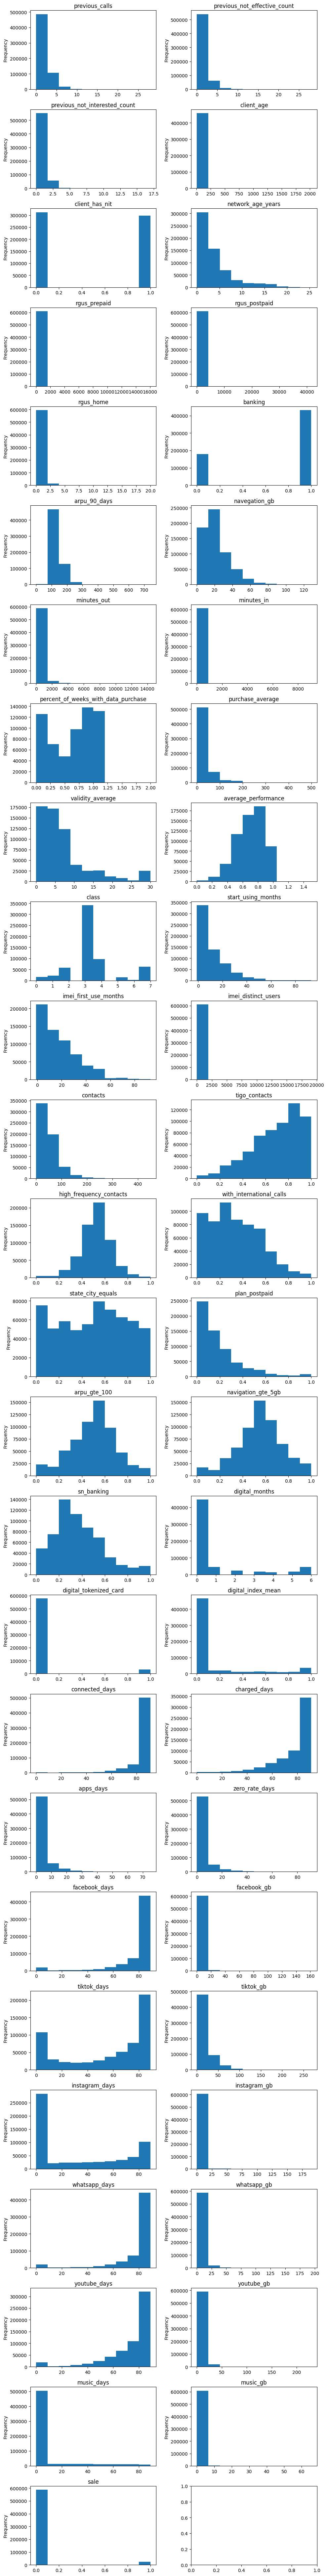

In [21]:


n = len(numerical_variables)
cols = 2
rows = math.ceil(n/cols)

fig, axes = plt.subplots(rows,cols, figsize=(cols*5,rows*3))
axes= axes.flatten()

for i, col in enumerate(numerical_variables):
    df[col].plot(kind='hist', ax=axes[i])
    axes[i].set_title(col)
    #axes[i].set_xlabel(col)
    #axes[i].set_ylabel('Counts')

plt.tight_layout()
plt.show()

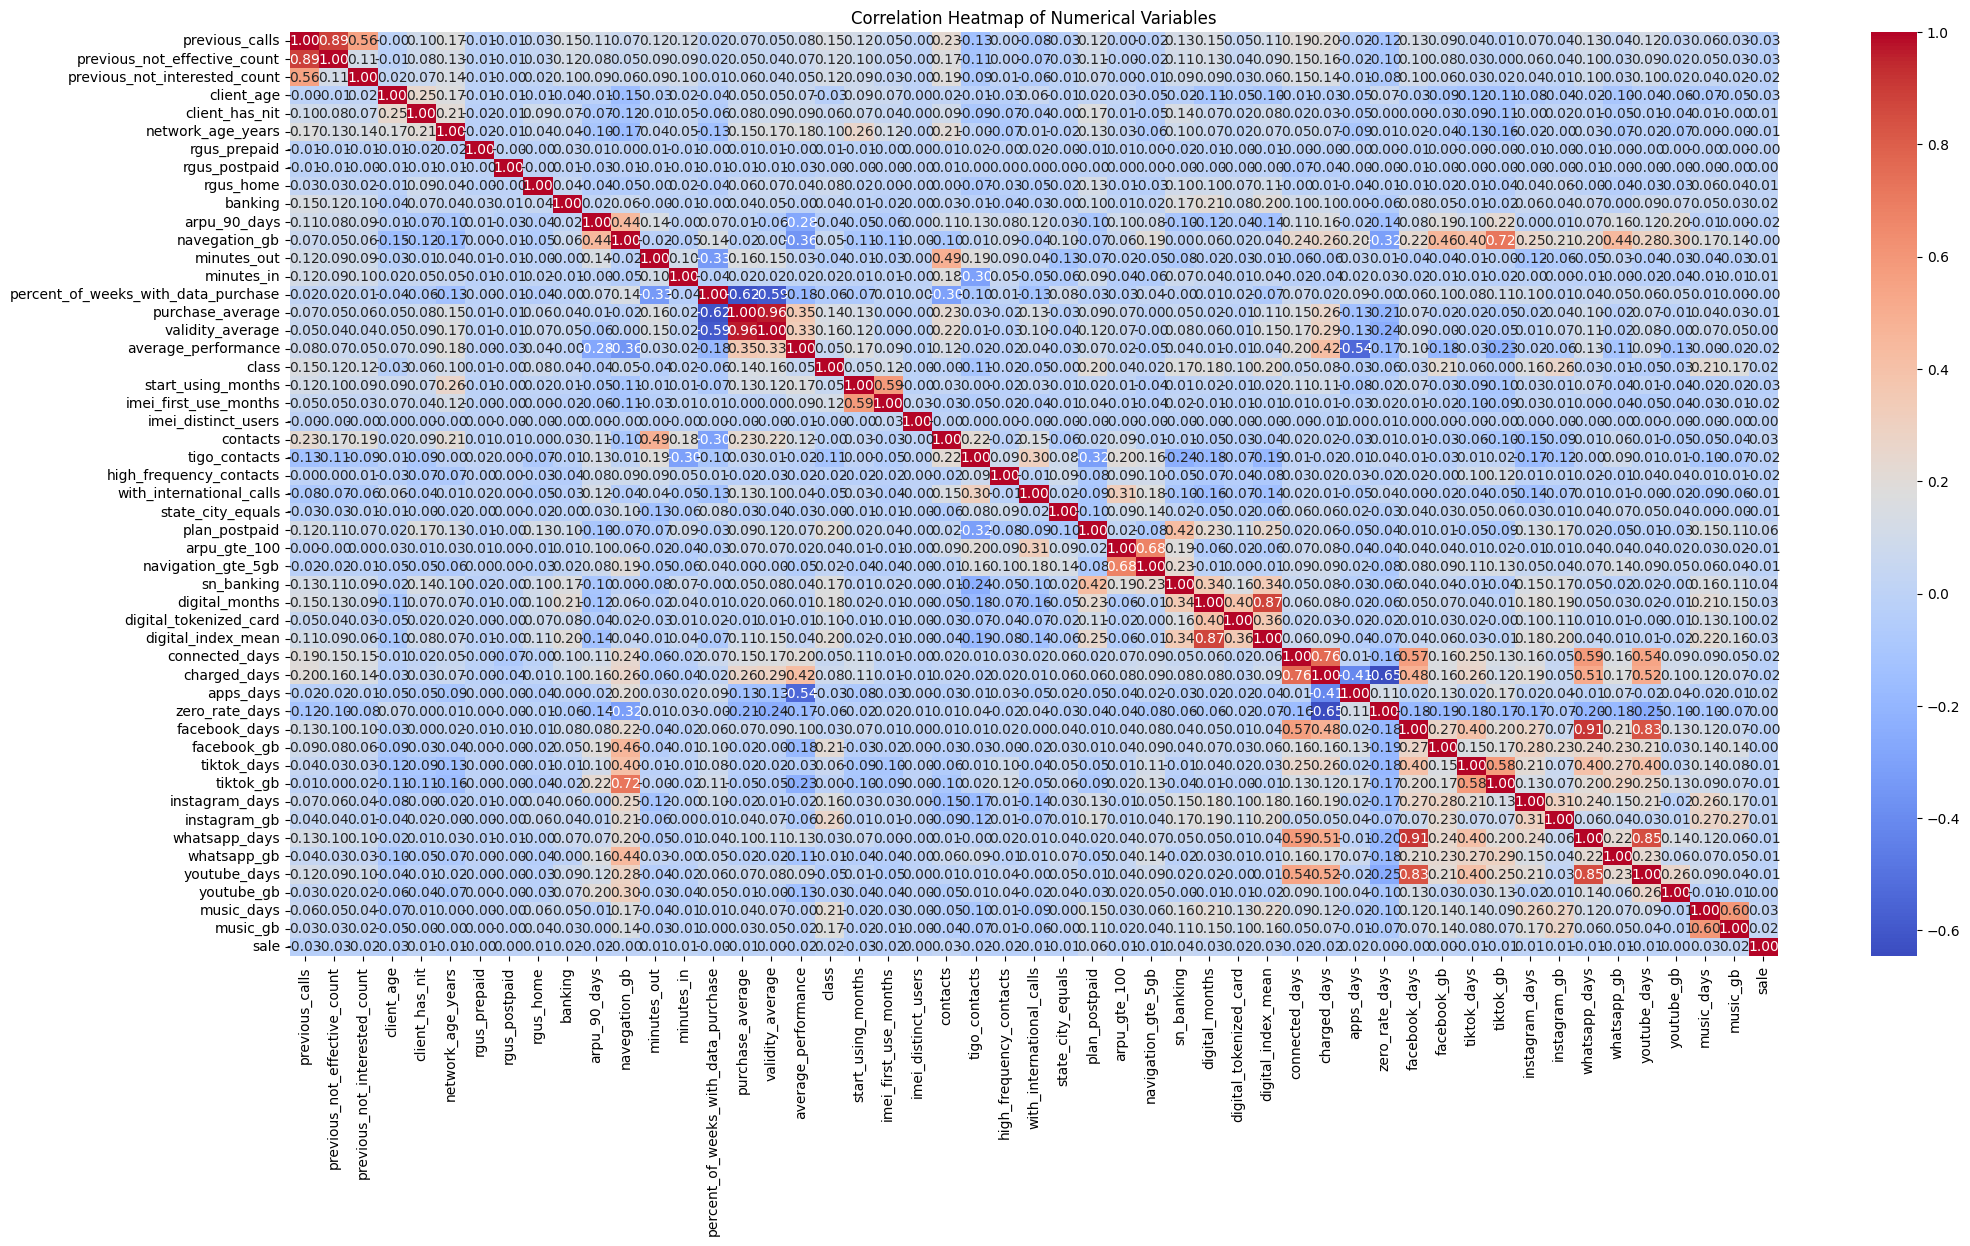

In [22]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(24, 12))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()

In [23]:
corr_matrix = df.corr(numeric_only=True).abs()

# Upper triangle mask
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

threshold = 0.5
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print("Highly correlated variables:", to_drop)

Highly correlated variables: ['previous_not_effective_count', 'previous_not_interested_count', 'purchase_average', 'validity_average', 'imei_first_use_months', 'navigation_gte_5gb', 'digital_index_mean', 'charged_days', 'apps_days', 'zero_rate_days', 'facebook_days', 'tiktok_gb', 'whatsapp_days', 'youtube_days', 'music_gb']


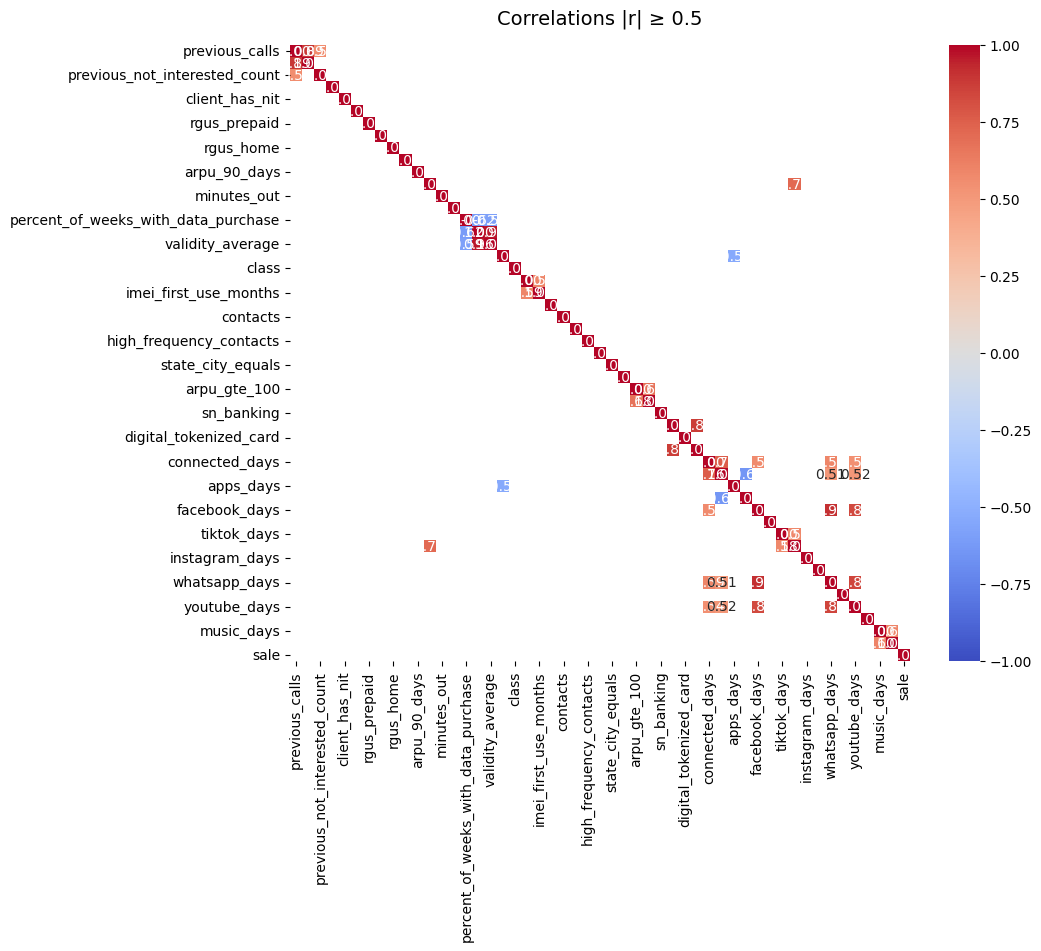

In [24]:
threshold = 0.5
mask = corr.abs() < threshold
filtered_corr = corr.mask(mask)

plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title(f"Correlations |r| ≥ {threshold}", fontsize=14, pad=15)
plt.show()

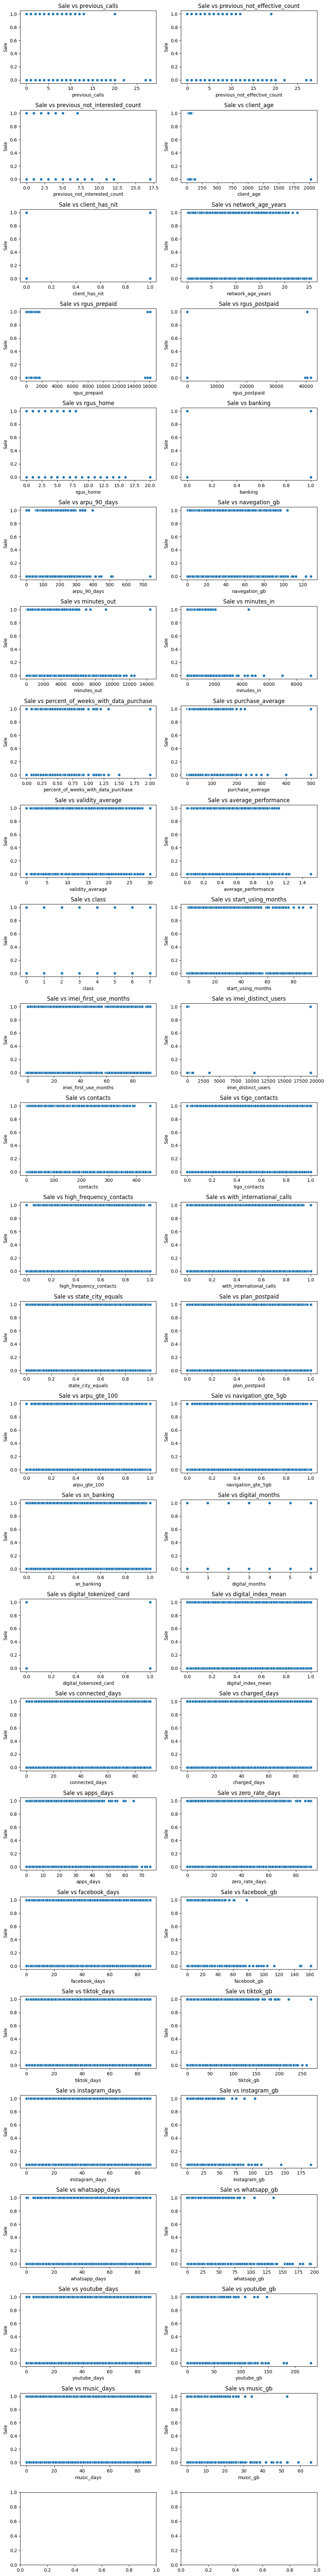

In [25]:

cols = 2

n = len(numerical_variables)

rows = math.ceil(n/cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3))

axes = axes.flatten()

num_feats = [num_col for num_col in numerical_variables if num_col != 'sale']

for i, col in enumerate(num_feats):
    sns.scatterplot(data=df, x=col, y='sale', ax=axes[i])
    axes[i].set_title(f"Sale vs {col}")
    axes[i].set_ylabel('Sale')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()




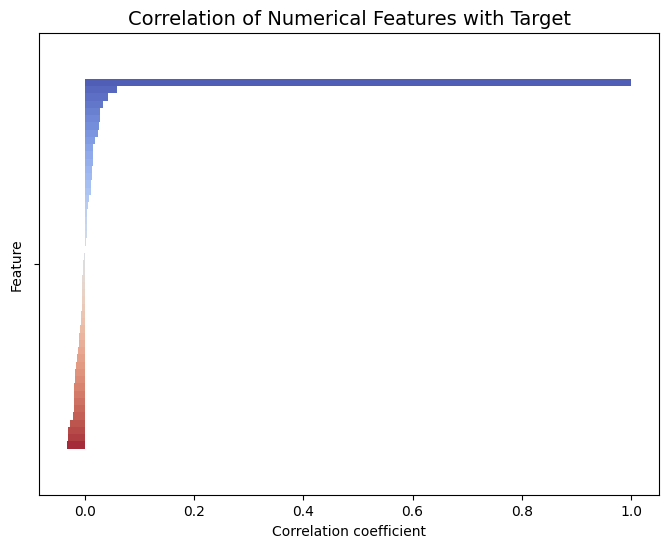

In [26]:
corr = df.corr(numeric_only=True)['sale'].sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=corr.values, hue=corr.index, palette="coolwarm", legend=False)
plt.title("Correlation of Numerical Features with Target", fontsize=14)
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.show()

#### missing numerical values

In [27]:
missing = df[numerical_variables].isna().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_percent.round(2)
})

missing_df

Missing Values  Percentage
client_age                                   151524       24.84
imei_distinct_users                              19        0.00
imei_first_use_months                            19        0.00
start_using_months                               19        0.00
class                                            19        0.00
network_age_years                                 2        0.00
previous_calls                                    0        0.00
facebook_days                                     0        0.00
digital_months                                    0        0.00
digital_tokenized_card                            0        0.00
digital_index_mean                                0        0.00
connected_days                                    0        0.00
charged_days                                      0        0.00
apps_days                                         0        0.00
zero_rate_days                                    0        0.00
facebook_gb                                       0        0.00
navigation_gte_5gb                                0        0.00
tiktok_days                                       0        0.00
tiktok_gb                                         0        0.00
instagram_days                                    0        0.00
instagram_gb                                      0        0.00
whatsapp_days                                     0        0.00
whatsapp_gb                                       0        0.00
youtube_days                                      0        0.00
youtube_gb                                        0        0.00
music_days                                        0        0.00
music_gb                                          0        0.00
sn_banking                                        0        0.00
with_international_calls                          0        0.00
arpu_gte_100                                      0        0.00
plan_postpaid                                     0        0.00
previous_not_interested_count                     0        0.00
client_has_nit                                    0        0.00
rgus_prepaid                                      0        0.00
rgus_postpaid                                     0        0.00
rgus_home                                         0        0.00
banking                                           0        0.00
arpu_90_days                                      0        0.00
navegation_gb                                     0        0.00
minutes_out                                       0        0.00
minutes_in                                        0        0.00
percent_of_weeks_with_data_purchase               0        0.00
purchase_average                                  0        0.00
validity_average                                  0        0.00
average_performance                               0        0.00
contacts                                          0        0.00
tigo_contacts                                     0        0.00
high_frequency_contacts                           0        0.00
previous_not_effective_count                      0        0.00
state_city_equals                                 0        0.00
sale                                              0        0.00

#### outliers

Outlier detection helps identify data points that deviate significantly from other observations.

In this notebook, boxplots are used (see next cell) to visualize outliers for each numerical variable. In a boxplot, outliers are typically shown as points outside the "whiskers" (which represent 1.5 times the interquartile range from the quartiles).

These outliers may indicate errors, rare events, or variability in the data, and can impact model performance.

Detecting and handling outliers is important for robust data analysis and modeling.

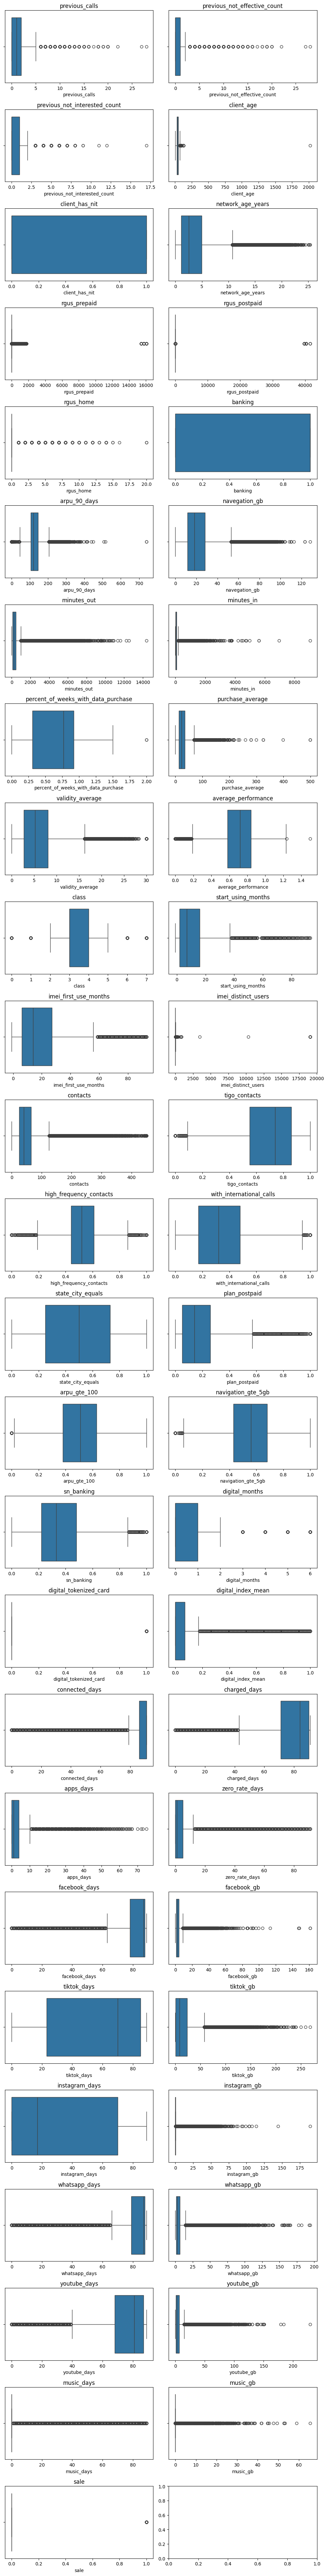

In [28]:
n = len(numerical_variables)

cols = 2
rows = math.ceil(n/cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3))

axes = axes.flatten()

for i, col in enumerate(numerical_variables):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

### 2.4.3 Categorical Variables

This dataset has 9 categorical variables

In [29]:
categorical_variables = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f'categorical variables: {len(categorical_variables)}')

categorical variables: 9


The following tables describes the categorical variables in the dataset making emphasis in:
* Count
* Top
* Frequency

In [30]:
df.describe(include="object").T

count unique                    top    freq
state_name               610068     22              GUATEMALA  104875
previous_classification  610083      3             NEW CLIENT  231950
client_gender            458428      2                      M  247019
socioeconomic_level      610083      6                      D  227175
network_technology_code  610064      4                     4G  554284
operating_system         610064      9                ANDROID  564097
type_name                610064      4             SMARTPHONE  609528
brand_name               610064    128                SAMSUNG  358068
model_name               610064   2382  SAMSUNG A10S 2GB+32GB   41674

#### A) Cardinal values
the following instruction will show the cardinal values for categorical variables

In [31]:
for cat_variable in categorical_variables[:-1]:
    print(f'[{cat_variable}] = {df[cat_variable].value_counts()}\n' )

[state_name] = state_name
GUATEMALA         104875
HUEHUETENANGO      66354
SAN MARCOS         56817
QUICHE             45712
ALTA VERAPAZ       38236
QUETZALTENANGO     37619
ESCUINTLA          30357
PETEN              25095
CHIMALTENANGO      24117
JUTIAPA            19469
SOLOLA             18671
TOTONICAPAN        18569
IZABAL             17901
SANTA ROSA         13704
SUCHITEPEQUEZ      13596
JALAPA             12974
CHIQUIMULA         12768
RETALHULEU         12229
ZACAPA             12102
BAJA VERAPAZ       10926
SACATEPEQUEZ       10873
EL PROGRESO         7104
Name: count, dtype: int64

[previous_classification] = previous_classification
NEW CLIENT        231950
NOT INTERESTED    201022
NOT EFFECTIVE     177111
Name: count, dtype: int64

[client_gender] = client_gender
M    247019
F    211409
Name: count, dtype: int64

[socioeconomic_level] = socioeconomic_level
D     227175
C-    156787
CC    108909
E      48852
C+     35455
AB     32905
Name: count, dtype: int64

[network_te

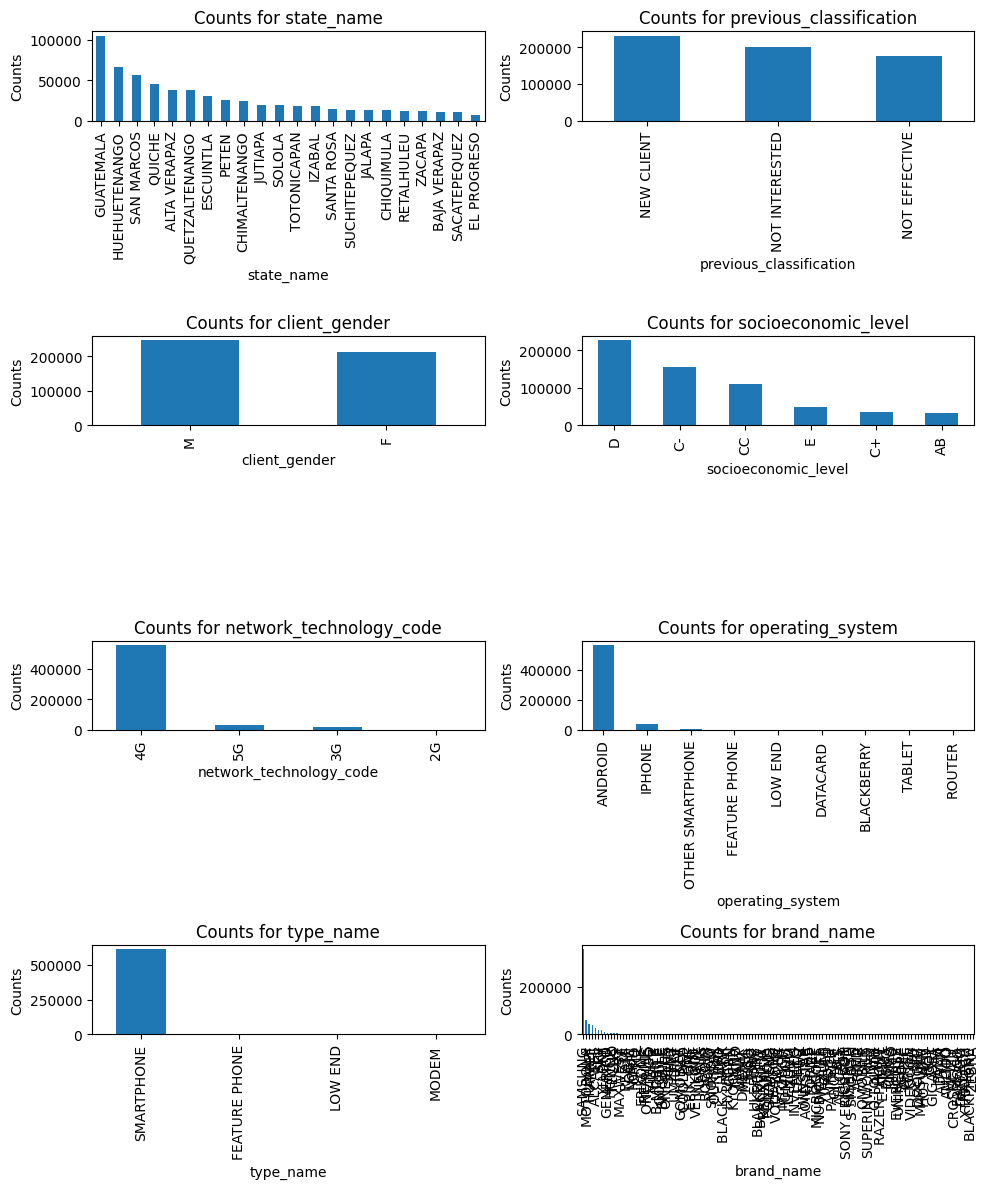

In [32]:

n = len(categorical_variables[:-1])
cols = 2
rows = math.ceil(n/cols)


fig, axes = plt.subplots(rows, cols, figsize=(cols*5,rows*3))

axes= axes.flatten()

for i, col in enumerate(categorical_variables[:-1]):
    df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Counts for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Counts')

plt.tight_layout()
plt.show()


#sns.barplot(data=df, x='state_name')

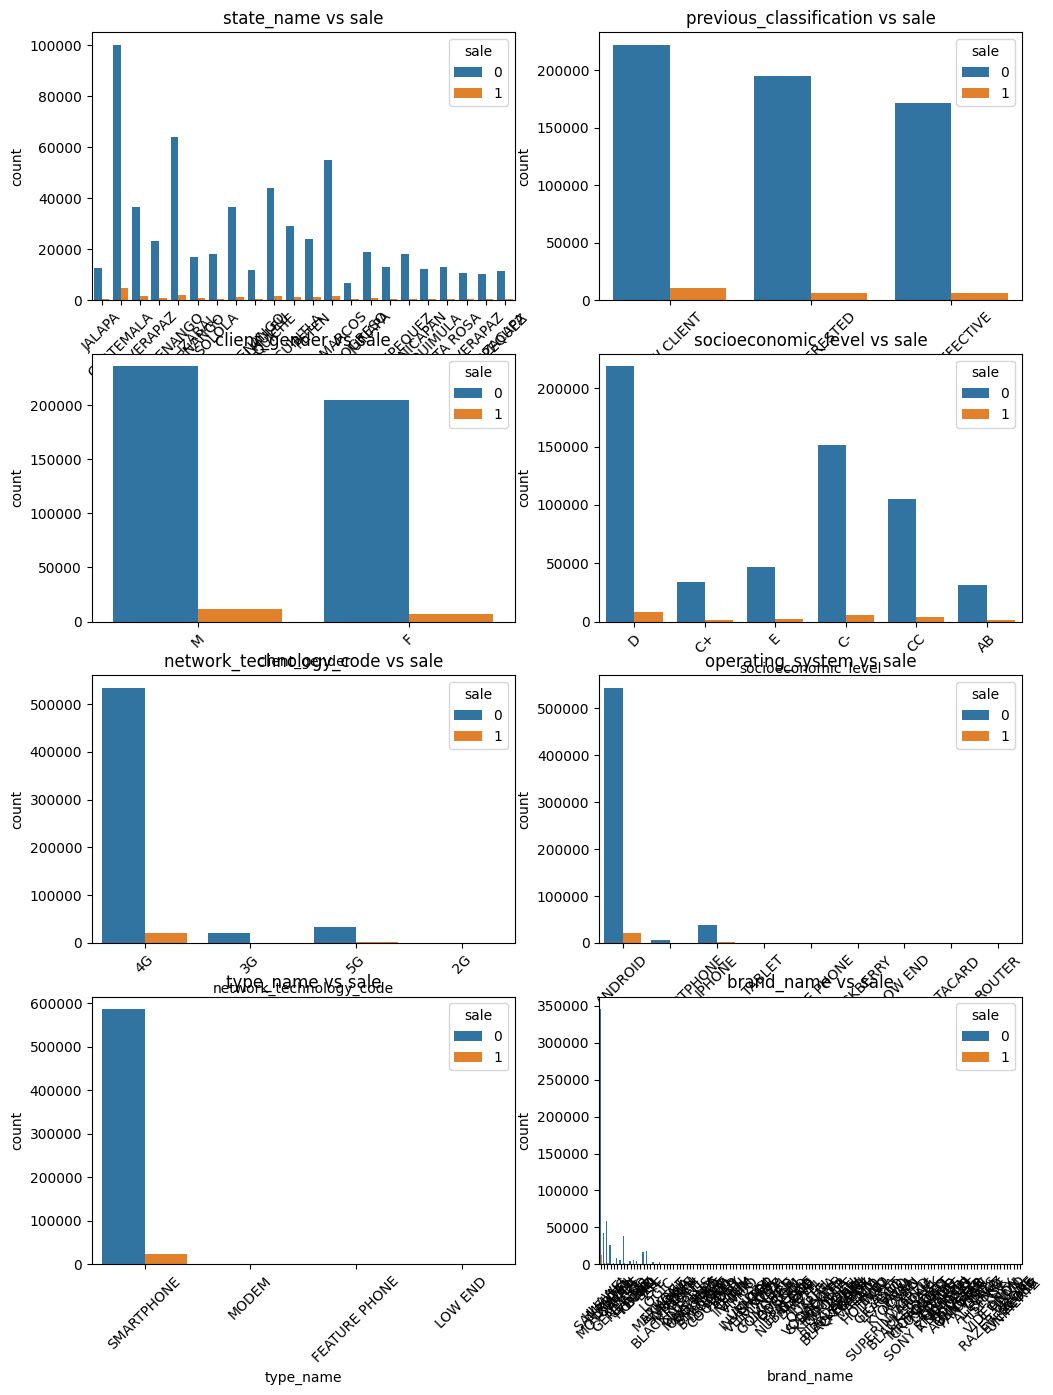

In [33]:

n = len(categorical_variables[:-1])
cols = 2
rows = math.ceil(n/cols)


fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, col in enumerate(categorical_variables[:-1]):
    sns.countplot(data=df, x=col, hue='sale', ax=axes[i])
    axes[i].set_title(f"{col} vs sale", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout
plt.show()

#### explaining proportion of sales respectly categorical vars

/var/folders/yv/wvk5jfnx7tq2zm0wb607sjnh0000gn/T/ipykernel_41108/3274198986.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=prop, x=col, y=target, ax=axes[i], palette="coolwarm")
/var/folders/yv/wvk5jfnx7tq2zm0wb607sjnh0000gn/T/ipykernel_41108/3274198986.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=prop, x=col, y=target, ax=axes[i], palette="coolwarm")
/var/folders/yv/wvk5jfnx7tq2zm0wb607sjnh0000gn/T/ipykernel_41108/3274198986.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=prop, x=col, y=target, ax=axes[i], 

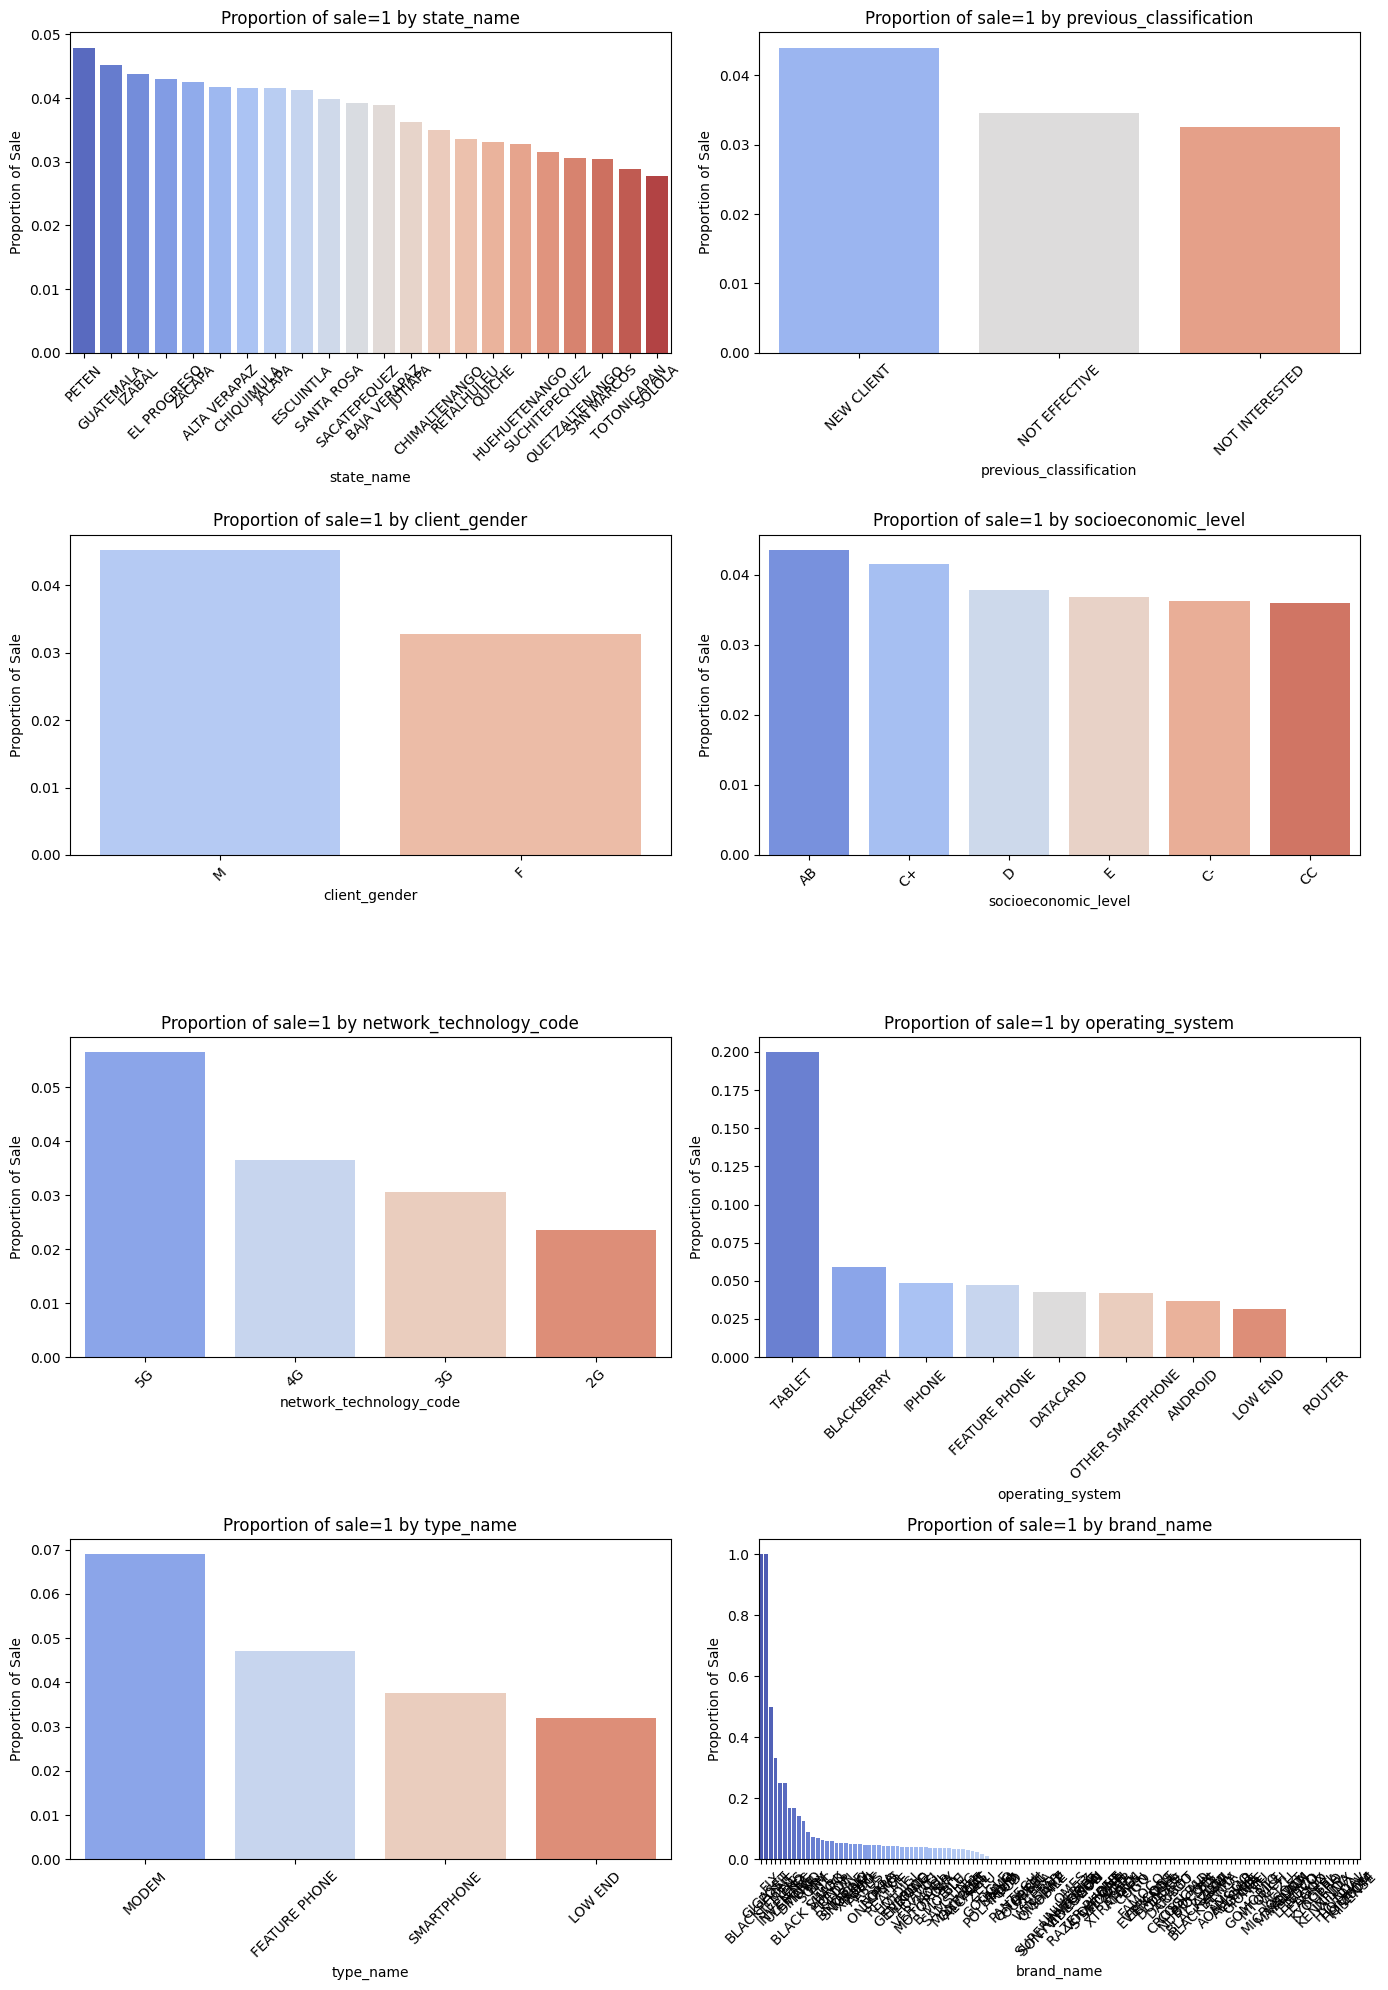

In [34]:
target = "sale"

cols = 2
rows = math.ceil(len(categorical_variables[:-1]) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*5))
axes = axes.flatten()

for i, col in enumerate(categorical_variables[:-1]):
    prop = (
        df.groupby(col)[target]
        .mean()
        .sort_values(ascending=False)
        .reset_index()
    )

    sns.barplot(data=prop, x=col, y=target, ax=axes[i], palette="coolwarm")
    axes[i].set_title(f"Proportion of {target}=1 by {col}", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel("Proportion of Sale")
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

#### Missing values

Identifying missing values in a dataset is a crucial step in the data preprocessing phase. Missing values can lead to inaccurate analyses, biased results, and errors in machine learning models. By detecting and handling missing data appropriately, we ensure the integrity and reliability of our subsequent data analysis and modeling processes.

In [35]:
missing = df[categorical_variables].isna().sum().sort_values(ascending=False)
missing_percent = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_percent.round(2)
})

missing_df

Missing Values  Percentage
client_gender                    151655       24.86
network_technology_code              19        0.00
operating_system                     19        0.00
type_name                            19        0.00
brand_name                           19        0.00
model_name                           19        0.00
state_name                           15        0.00
previous_classification               0        0.00
socioeconomic_level                   0        0.00

*EDA*

Across all cuts the conversion rate is low (~3–5%), confirming **strong class imbalance**. Categorical signals are material: **previous_classification** is highly informative (NEW CLIENT highest, NOT INTERESTED lowest), **socioeconomic_level** shows a clear gradient (A/B, C+ > C/D/E), and **state_name** differences are present but secondary. **Technology and device** matter: 5G > 4G > 3G > 2G in sale proportion; **SMARTPHONE** dominates volume, while categories like **MODEM/TABLET/BLACKBERRY** can show high lift but with **small sample sizes**; **Android** concentrates most of the base. **brand_name** exhibits a long tail (high cardinality), requiring careful encoding.

Operationally, this suggests prioritizing campaigns toward segments with better **lift × volume** (NEW CLIENT, 4G/5G, higher socioeconomic tiers, smartphones) while tailoring scripts for low-propensity niches (NOT INTERESTED, 2G/3G). For modeling, expect **non-linear, multifactor effects**; use encodings aligned to cardinality (target vs one-hot), **rebalance classes**, and set the operating threshold via **precision/recall/F1** trade-offs. Finally, control for small-n volatility in niche device/OS buckets and keep explainability (e.g., **SHAP**) to translate scores into actionable reasons for telemarketing.


## Select Features

Feature selection is justified to enhance model accuracy, reduce overfitting, and simplify interpretation. By removing highly correlated, irrelevant, or redundant features, the model focuses on variables most likely to influence the target (`sale`). This approach also addresses issues like multicollinearity and missing data, ensuring the model is robust and generalizes well to new data. Selected features reflect both statistical relevance and practical business insights, supporting reliable predictions and actionable results.

In [36]:
selected_columns = [
    'state_name'
    , 'previous_classification'
    , 'previous_calls'
    #, 'previous_not_effective_count'
    #, 'previous_not_interested_count'
    #, 'client_gender'
    , 'client_age'
    #, 'client_has_nit'
    , 'network_age_years'
    #, 'rgus_prepaid'
    #, 'rgus_postpaid'
    #, 'rgus_home'
    , 'banking'
    , 'arpu_90_days'
    #, 'navegation_gb'
    #, 'minutes_out'
    , 'minutes_in'
    #, 'percent_of_weeks_with_data_purchase'
    #, 'purchase_average'
    , 'validity_average'
    , 'average_performance'
    #, 'socioeconomic_level'
    #, 'network_technology_code'
    #, 'operating_system'
    #, 'type_name'
    #, 'brand_name'
    #, 'model_name'
    #, 'class'
    , 'start_using_months'
    #, 'imei_first_use_months'
    #, 'imei_distinct_users'
    , 'contacts'
    #, 'tigo_contacts'
    , 'high_frequency_contacts'
    #, 'with_international_calls'
    #, 'state_city_equals'
    , 'plan_postpaid'
    #, 'arpu_gte_100'
    #, 'navigation_gte_5gb'
    , 'sn_banking'
    #, 'digital_months'
    #, 'digital_tokenized_card'
    , 'digital_index_mean'
    , 'connected_days'
    , 'charged_days'
    , 'apps_days'
    #, 'zero_rate_days'
    #, 'facebook_days'
    #, 'facebook_gb'
    #, 'tiktok_days'
    #, 'tiktok_gb'
    #, 'instagram_days'
    #, 'instagram_gb'
    #, 'whatsapp_days'
    #, 'whatsapp_gb'
    #, 'youtube_days'
    #, 'youtube_gb'
    #, 'music_days'
    , 'music_gb'
    , 'sale'
]

In [37]:
len(selected_columns)

21

In [38]:
df_selected = df[selected_columns]

In [39]:
df_selected.shape

(610083, 21)

## Train/Test Split

In [40]:
df_train=df_selected.sample(frac=0.7,random_state=100)
df_test=df_selected.drop(df_train.index)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [41]:
df_train.shape

(427058, 21)

In [42]:
df_test.shape

(183025, 21)

In [43]:
df_train.describe()

previous_calls     client_age  network_age_years        banking  \
count   427058.000000  320879.000000      427057.000000  427058.000000   
mean         1.406413      41.240527           3.753322       0.706590   
std          1.656201      12.445169           3.816367       0.455325   
min          0.000000       7.000000           0.010000       0.000000   
25%          0.000000      32.000000           1.090000       0.000000   
50%          1.000000      40.000000           2.530000       1.000000   
75%          2.000000      49.000000           4.950000       1.000000   
max         27.000000    2022.000000          25.370000       1.000000   

        arpu_90_days     minutes_in  validity_average  average_performance  \
count  427058.000000  427058.000000     427058.000000        427058.000000   
mean      129.689491      69.549010          7.122910             0.699338   
std        34.498689     110.727144          6.675478             0.179308   
min         0.000000       0.000000          0.000000             0.000000   
25%       105.010000      13.390000          2.680000             0.580000   
50%       120.220000      35.990000          5.240000             0.720000   
75%       145.380000      82.910000          8.110000             0.840000   
max       740.730000    9047.500000         30.000000             1.500000   

       start_using_months       contacts  high_frequency_contacts  \
count       427040.000000  427058.000000            427058.000000   
mean            10.769570      50.255820                 0.521763   
std             11.361819      38.084258                 0.133990   
min             -1.000000       0.000000                 0.000000   
25%              2.000000      25.000000                 0.440000   
50%              7.000000      41.000000                 0.520000   
75%             16.000000      65.000000                 0.610000   
max             93.000000     450.000000                 1.000000   

       plan_postpaid     sn_banking  digital_index_mean  connected_days  \
count  427058.000000  427058.000000       427058.000000   427058.000000   
mean        0.186584       0.365271            0.138517       85.851058   
std         0.190468       0.214550            0.287477       10.309549   
min         0.000000       0.000000            0.000000        0.000000   
25%         0.050000       0.220000            0.000000       86.000000   
50%         0.140000       0.330000            0.000000       91.000000   
75%         0.260000       0.480000            0.060000       91.000000   
max         1.000000       1.000000            1.000000       91.000000   

        charged_days      apps_days       music_gb           sale  
count  427058.000000  427058.000000  427058.000000  427058.000000  
mean       77.824621       3.388500       0.194037       0.037367  
std        16.046937       5.732648       0.897738       0.189660  
min         0.000000       0.000000       0.000000       0.000000  
25%        71.000000       0.000000       0.000000       0.000000  
50%        84.000000       1.000000       0.000000       0.000000  
75%        90.000000       4.000000       0.000000       0.000000  
max        91.000000      75.000000      65.499000       1.000000

## Explanation of Transformations

The pipeline applies several transformations to prepare the data for modeling:

- **Target Encoding (`state_name`)**: Converts categorical values into numerical representations based on the target variable, improving predictive power for categorical features.
- **One Hot Encoding (`previous_classification`)**: Expands categorical variables into multiple binary columns, allowing models to interpret categories independently.
- **Outlier Handling & Imputation (`client_age`, `network_age_years`, `start_using_months`)**: Sets out-of-range values to NaN and imputes missing values using the median, ensuring data consistency and reducing bias from missing data.
- **Truncation (`minutes_in`, `average_performance`)**: Caps values at specified thresholds to limit the influence of extreme outliers.
- **Quantile Transformation**: Applies a quantile-based normalization to selected numerical features, making their distributions more Gaussian-like and improving model performance.
- **Yeo-Johnson Transformation**: Applies a power transformation to selected features, stabilizing variance and making data more normal-distributed.
- **Debug Step**: Outputs the shape and saves the transformed data for inspection.
- **Classifier**: Trains the XGBoost model on the processed features.

These steps collectively clean, normalize, and encode the data, ensuring robust and effective model training.

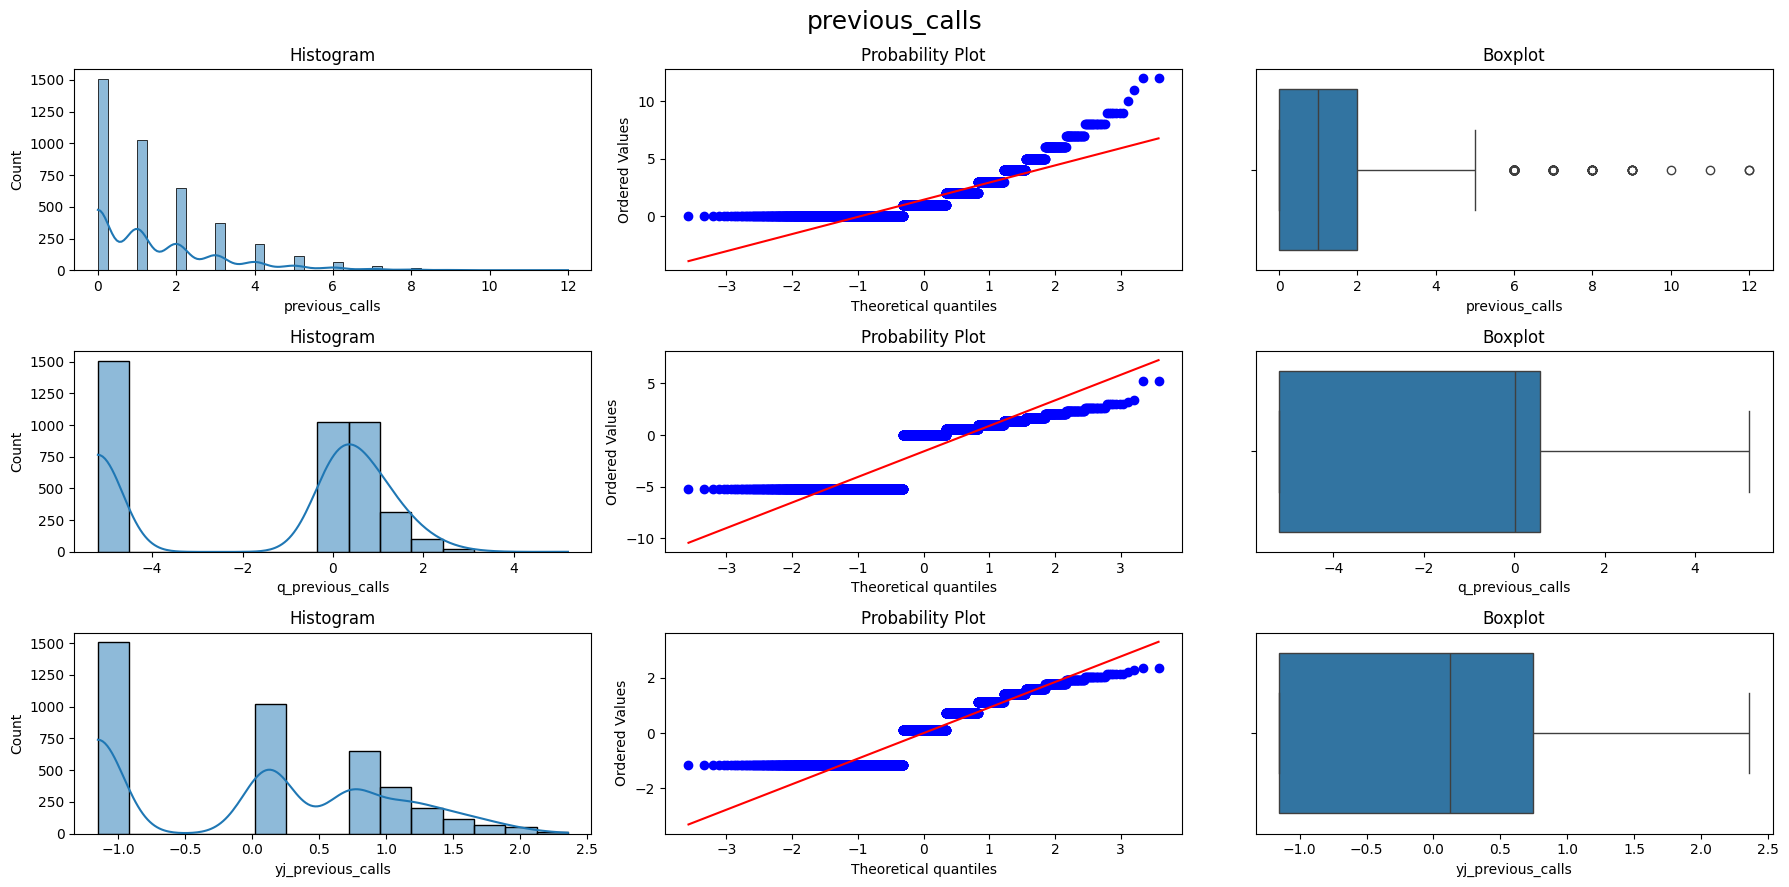

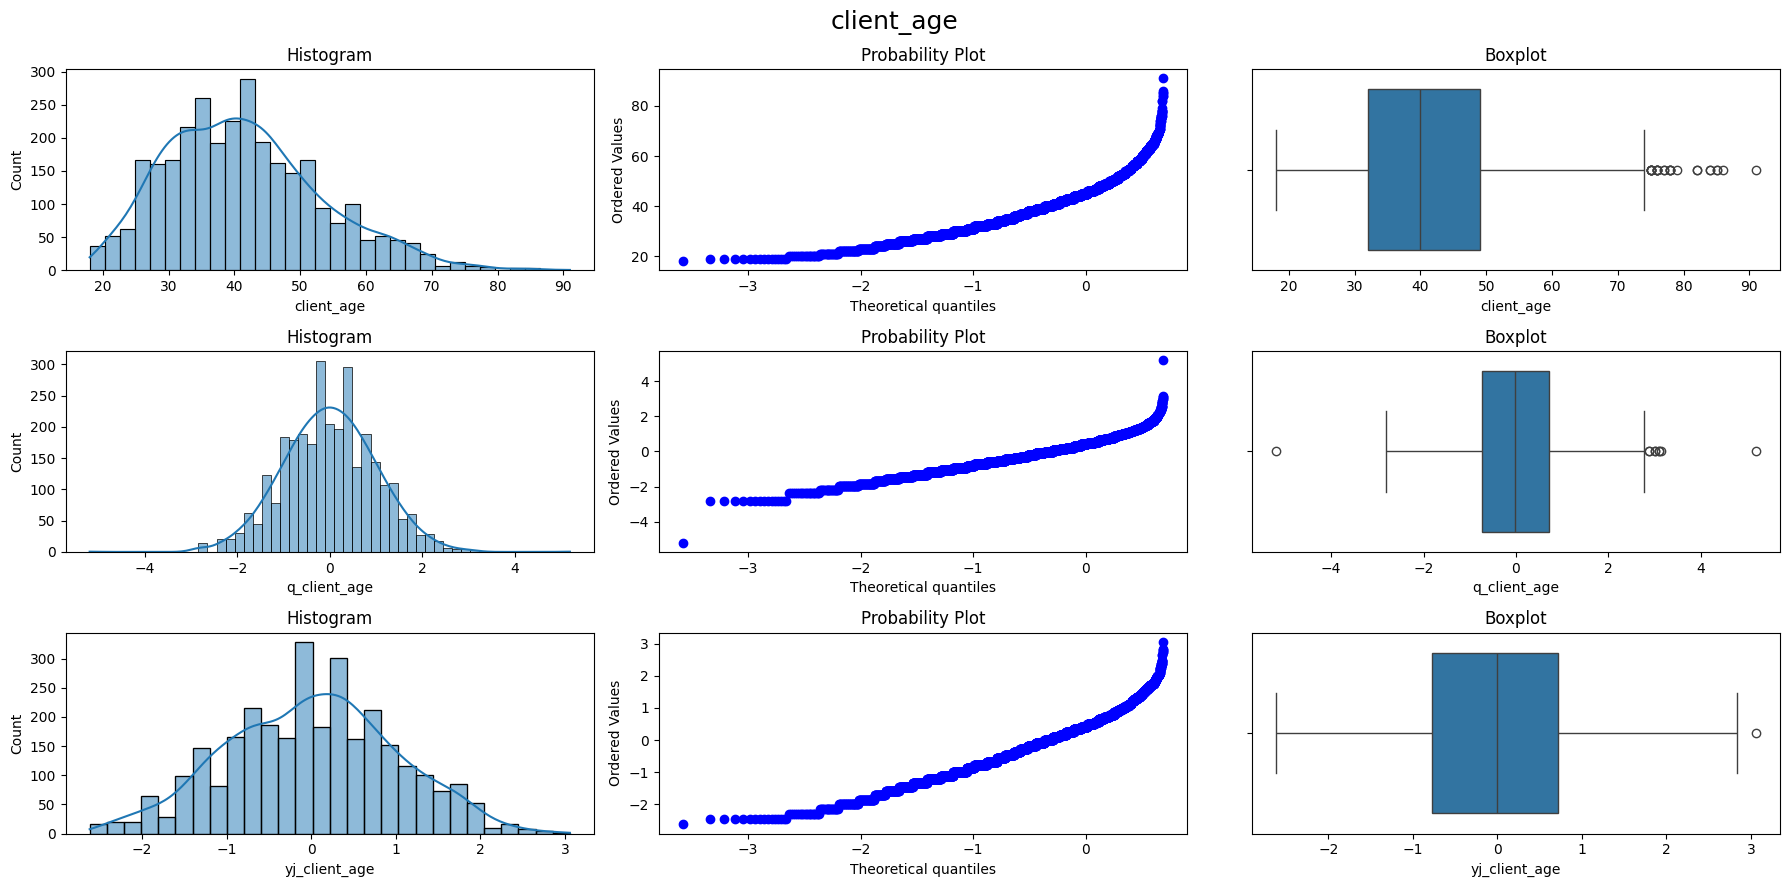

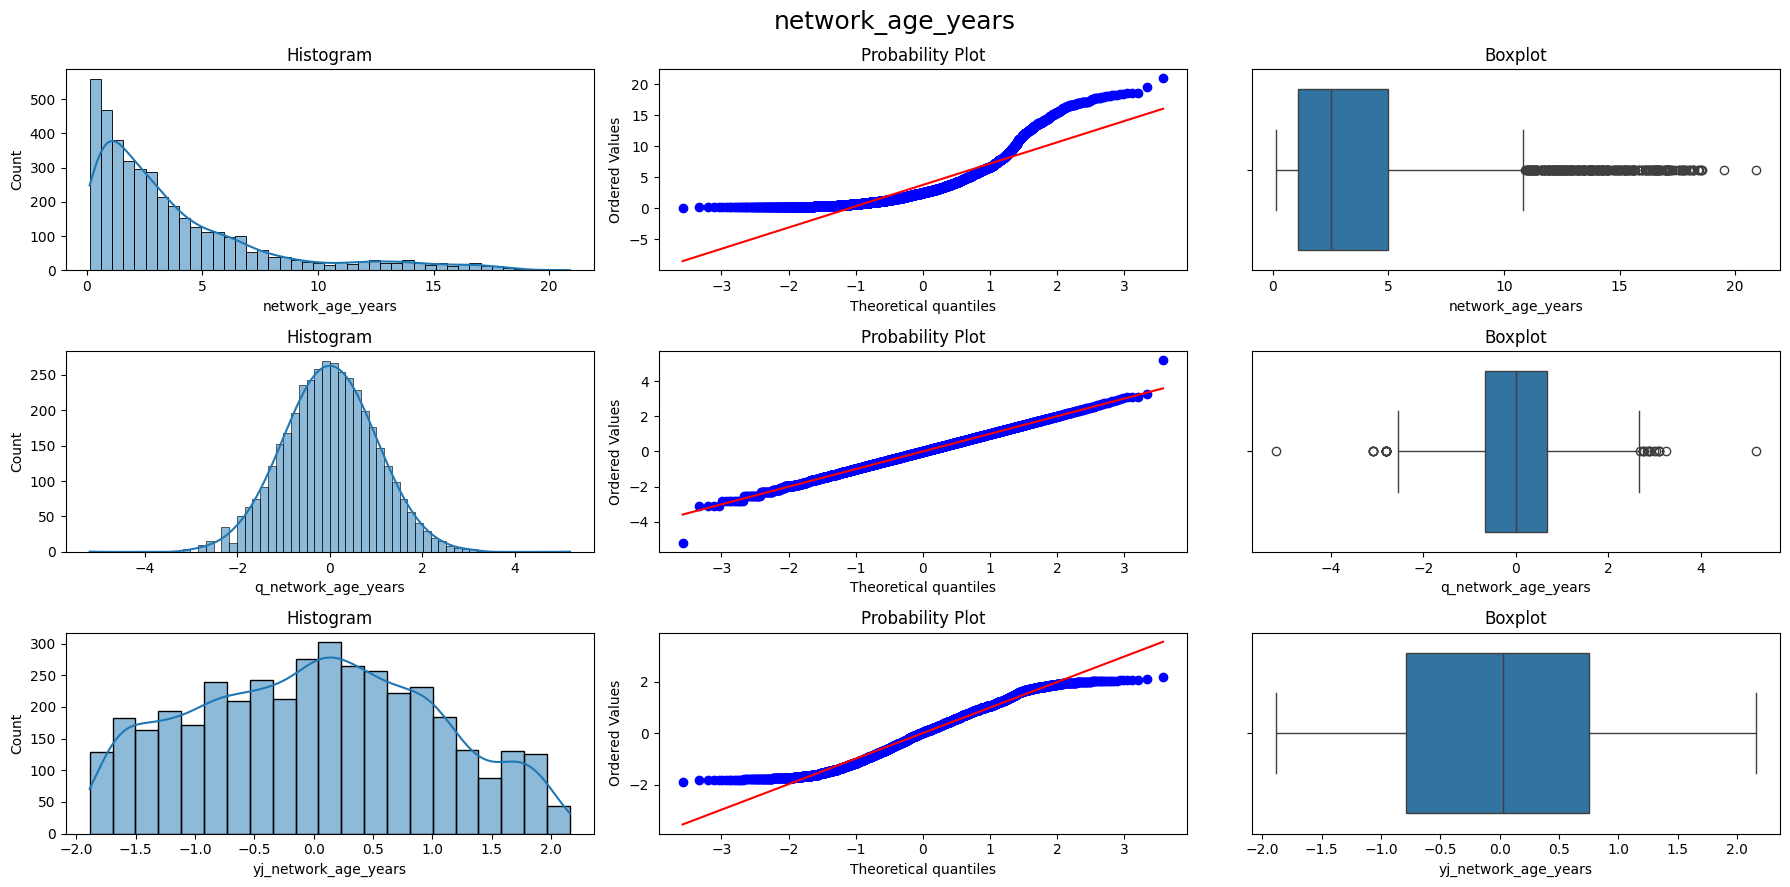

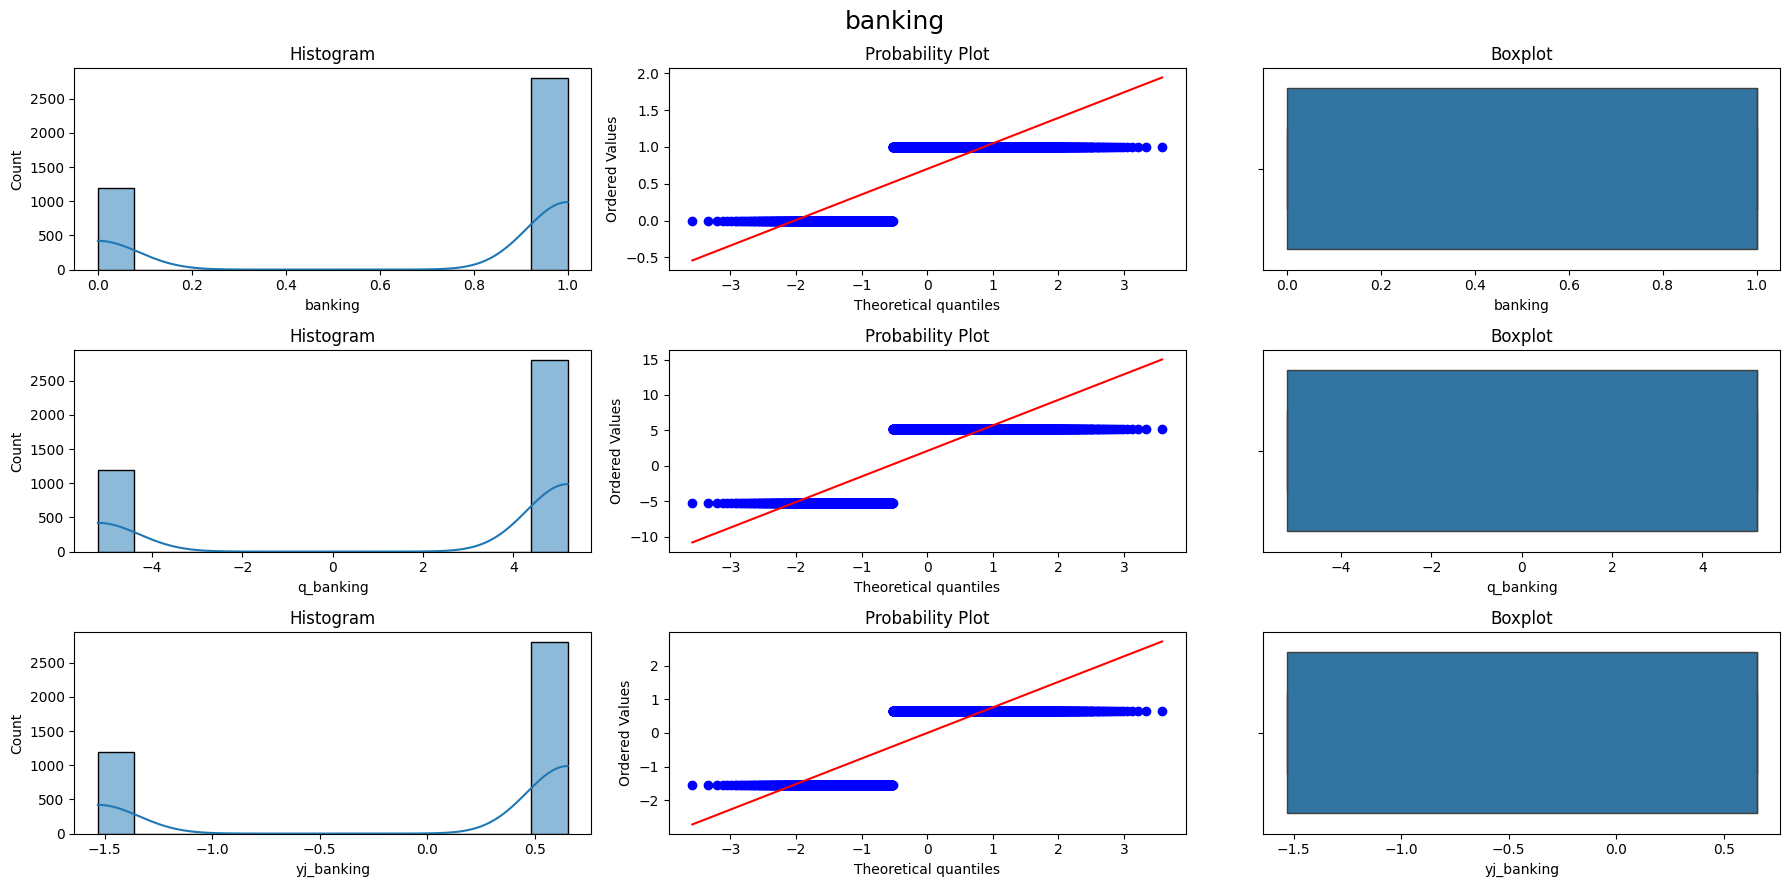

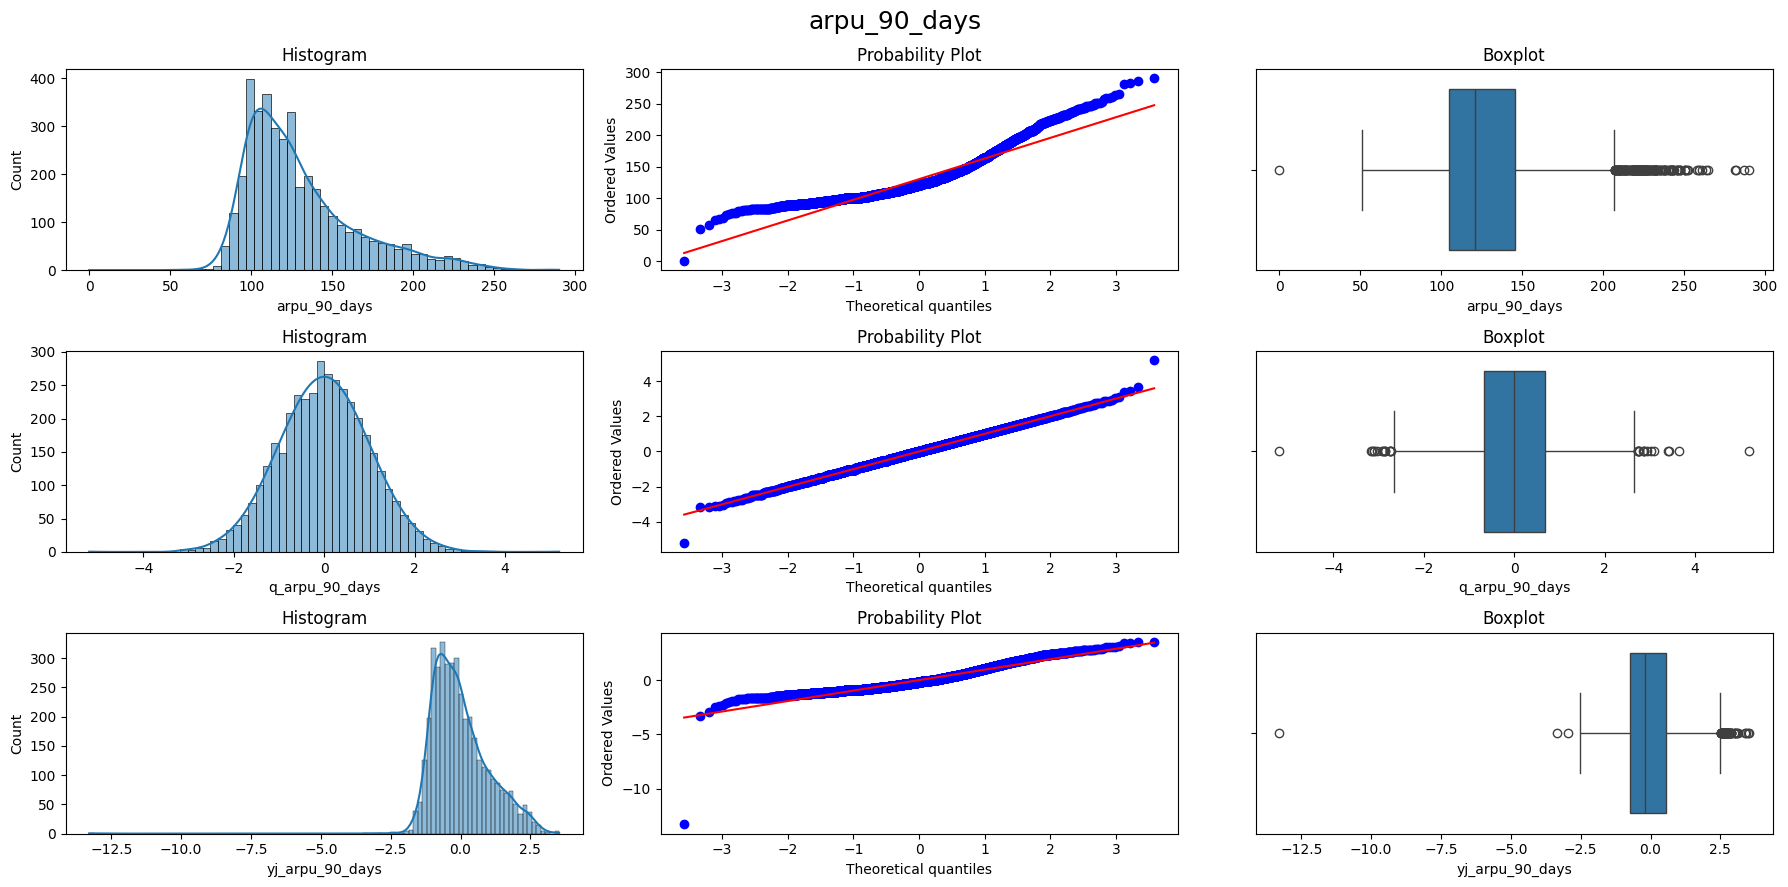

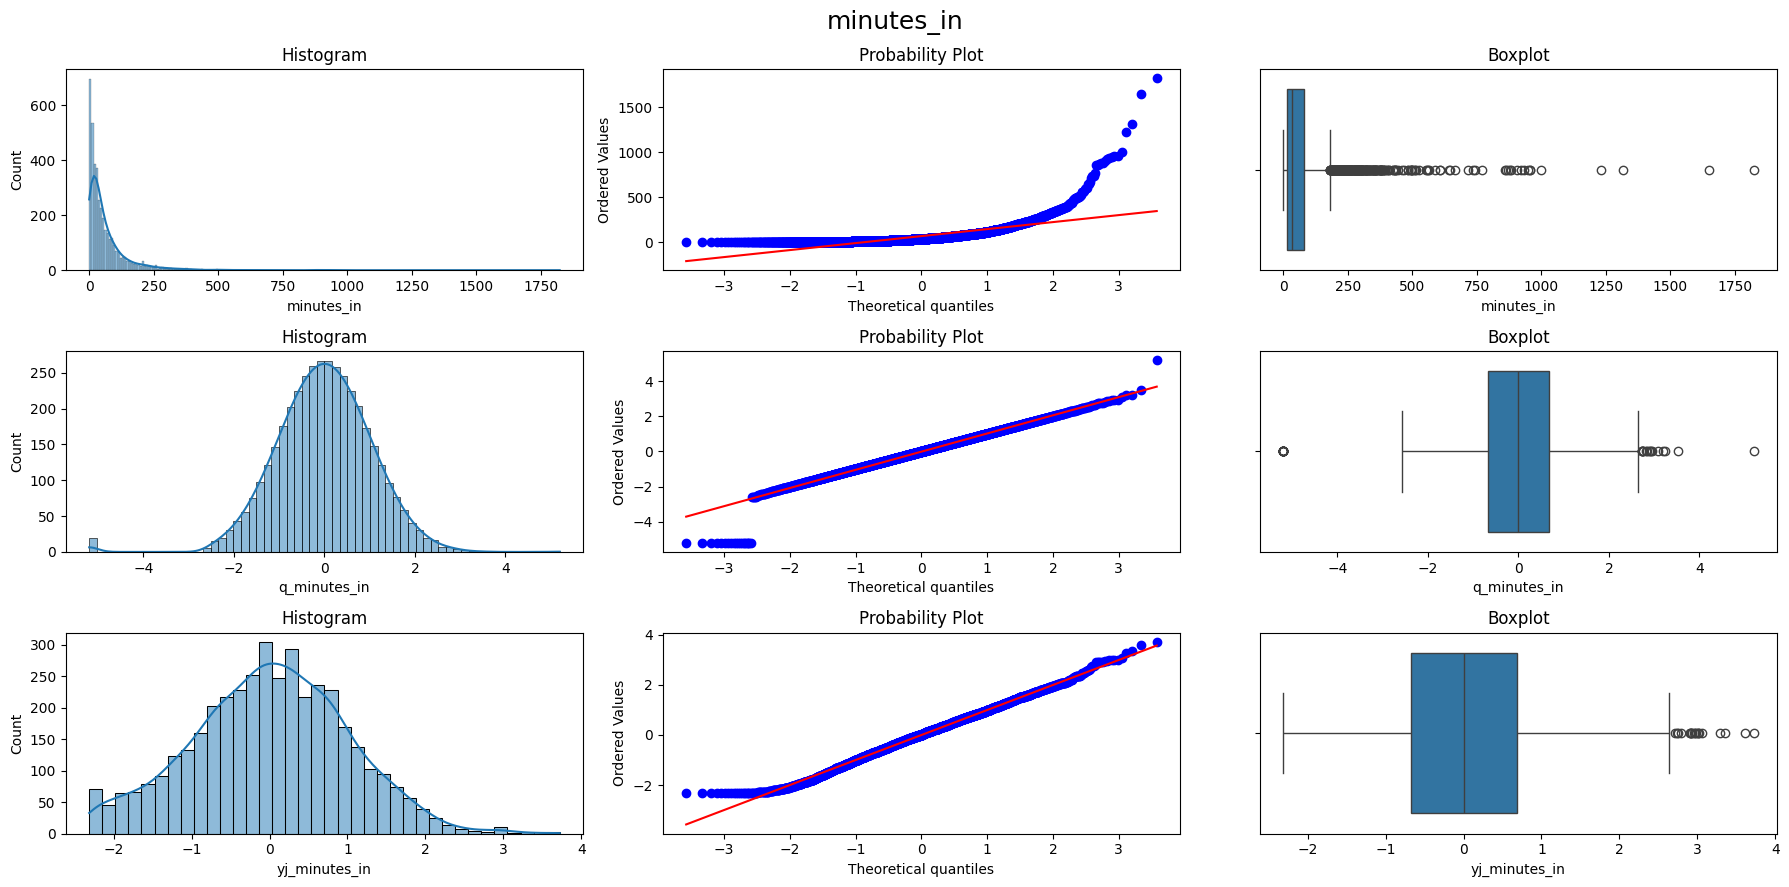

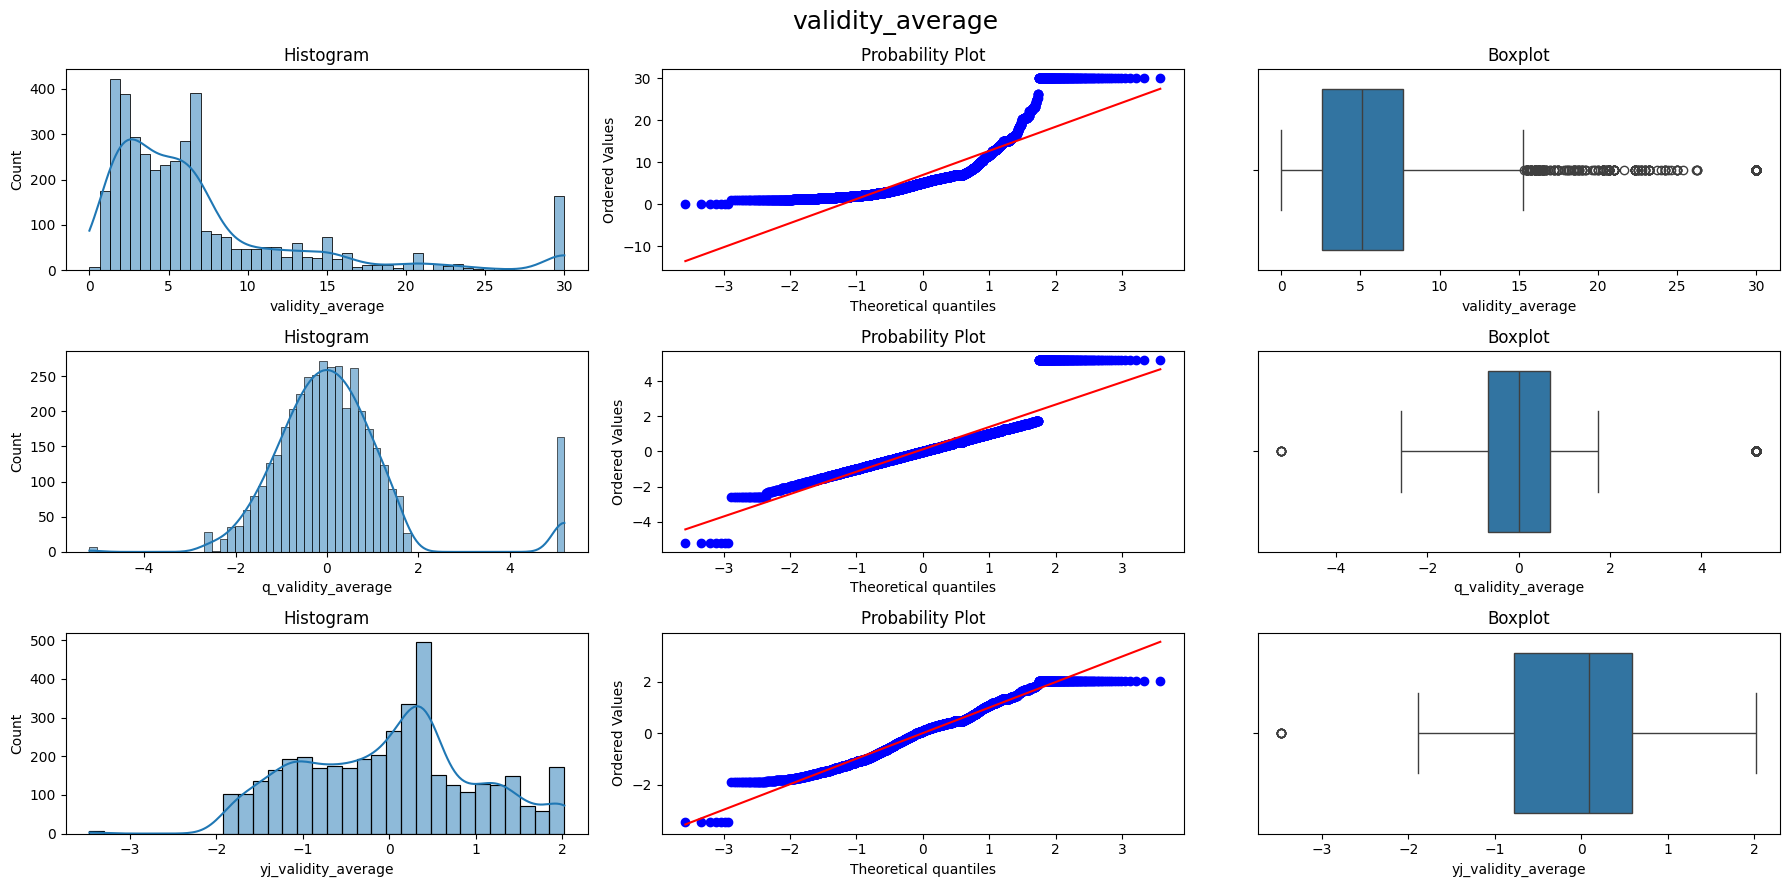

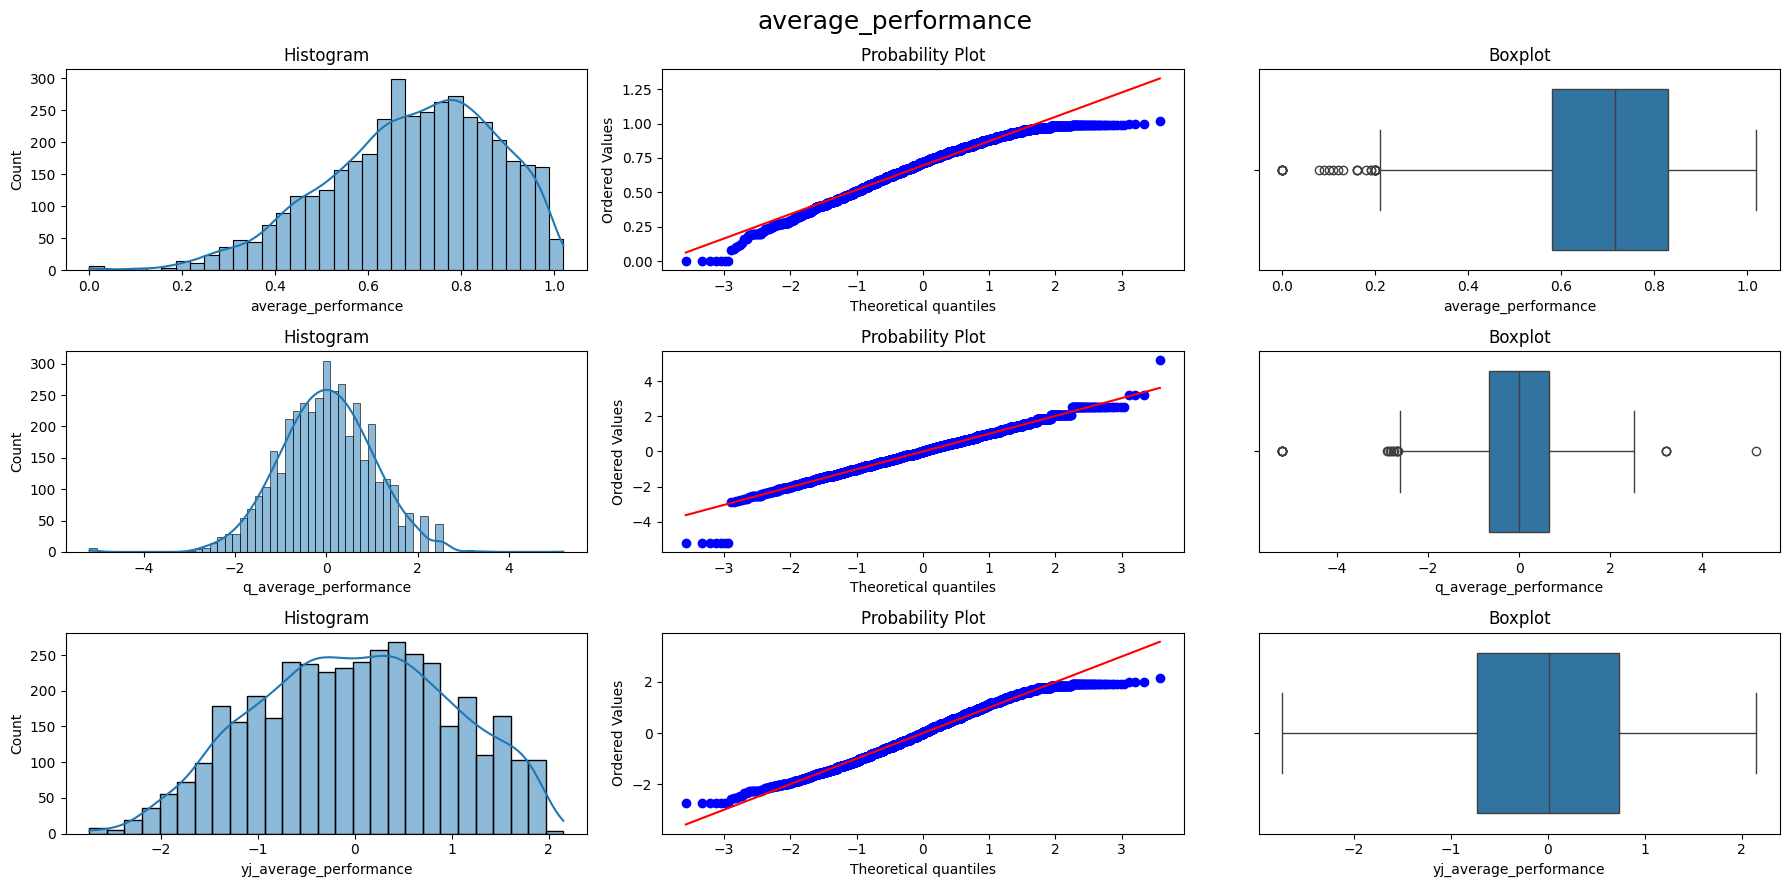

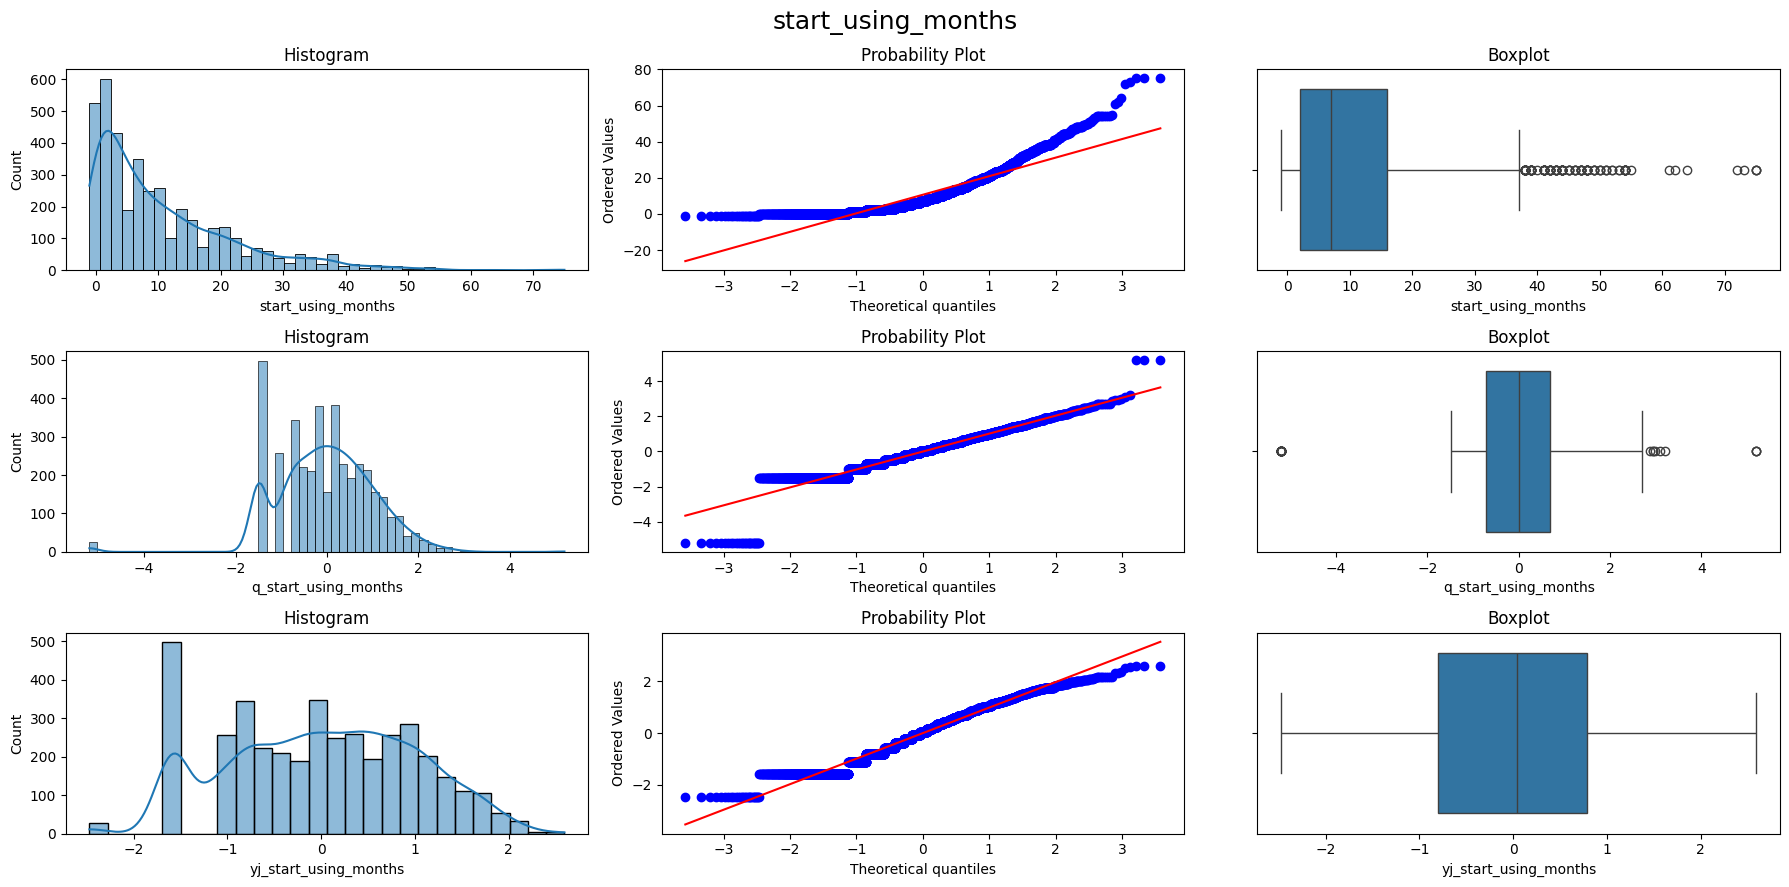

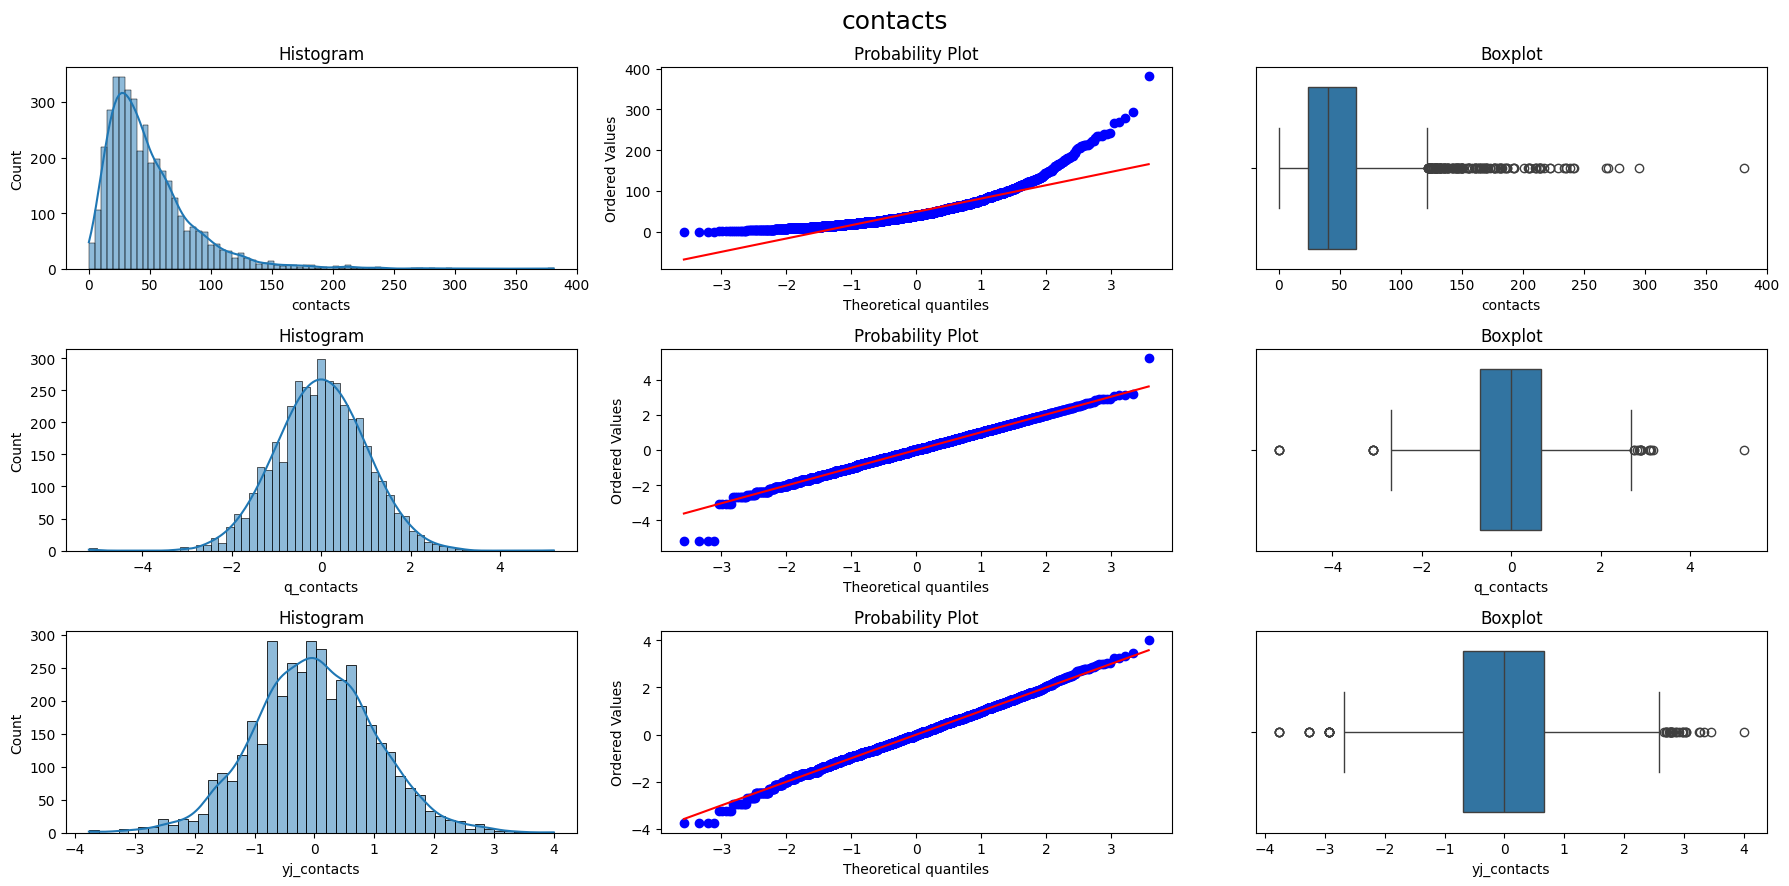

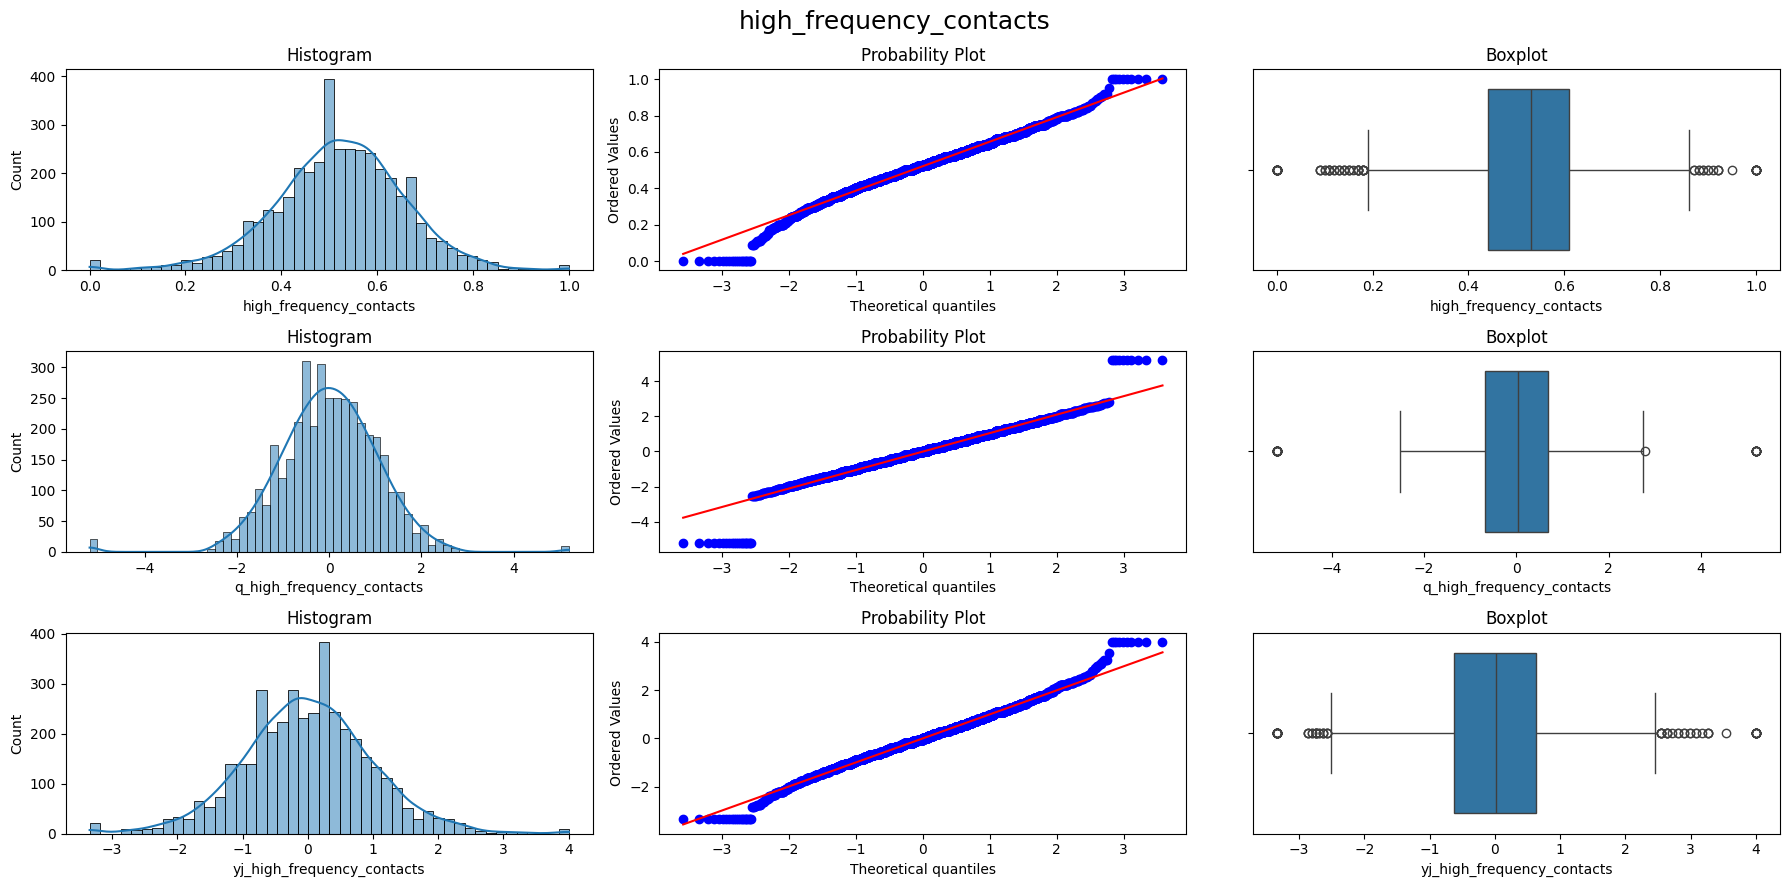

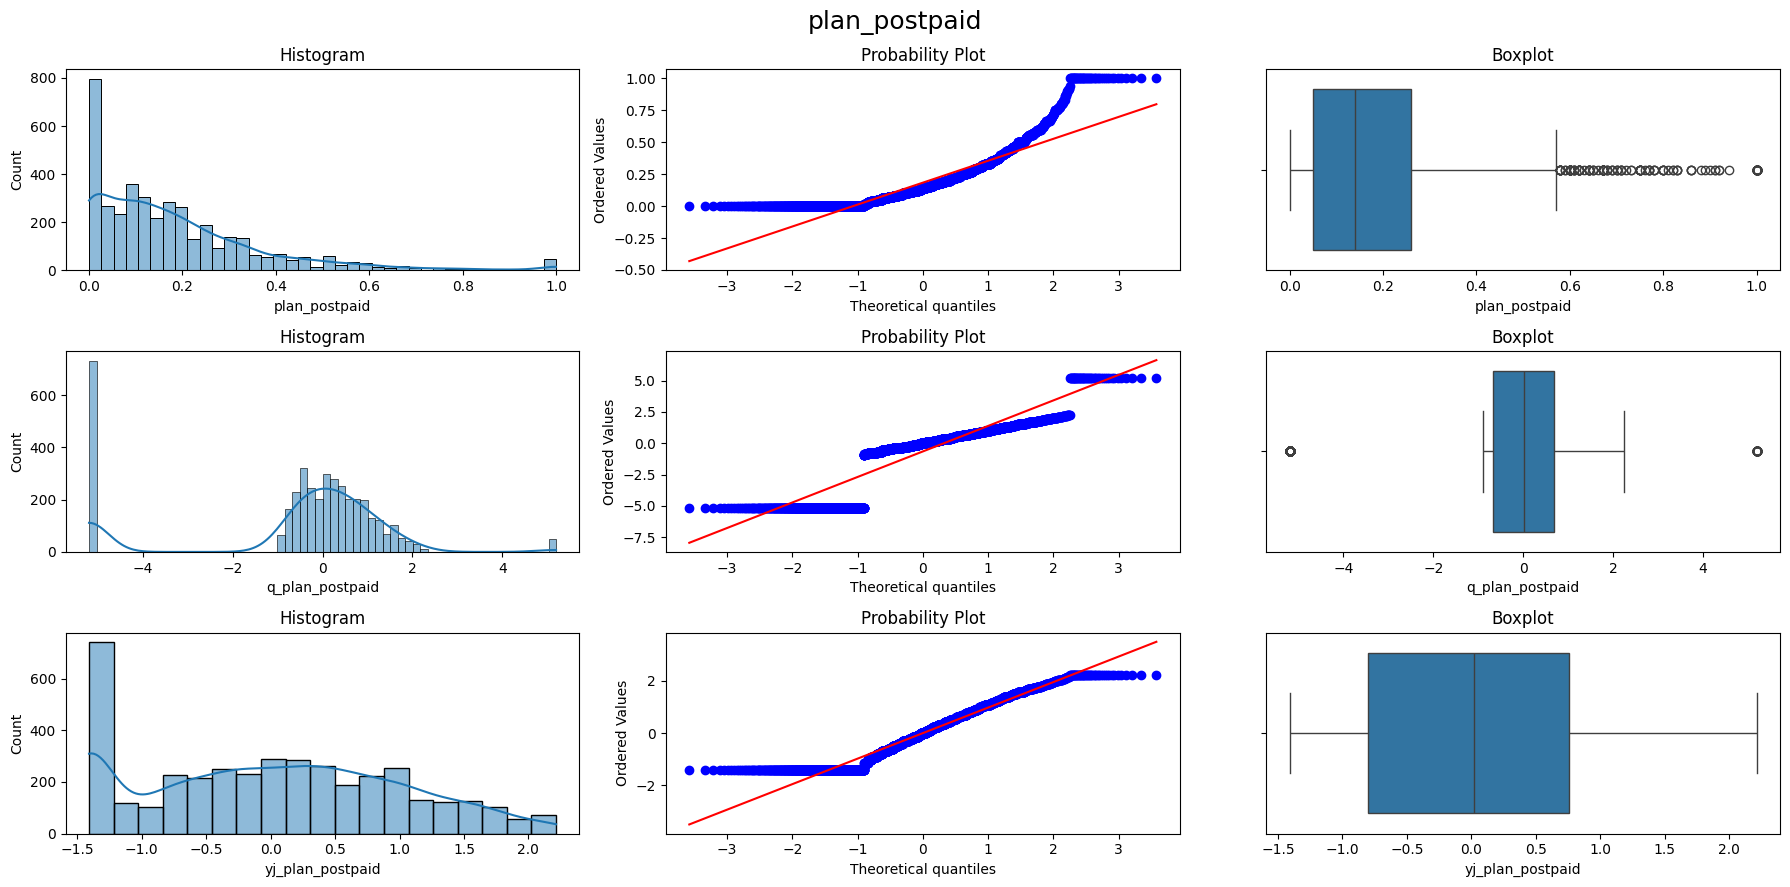

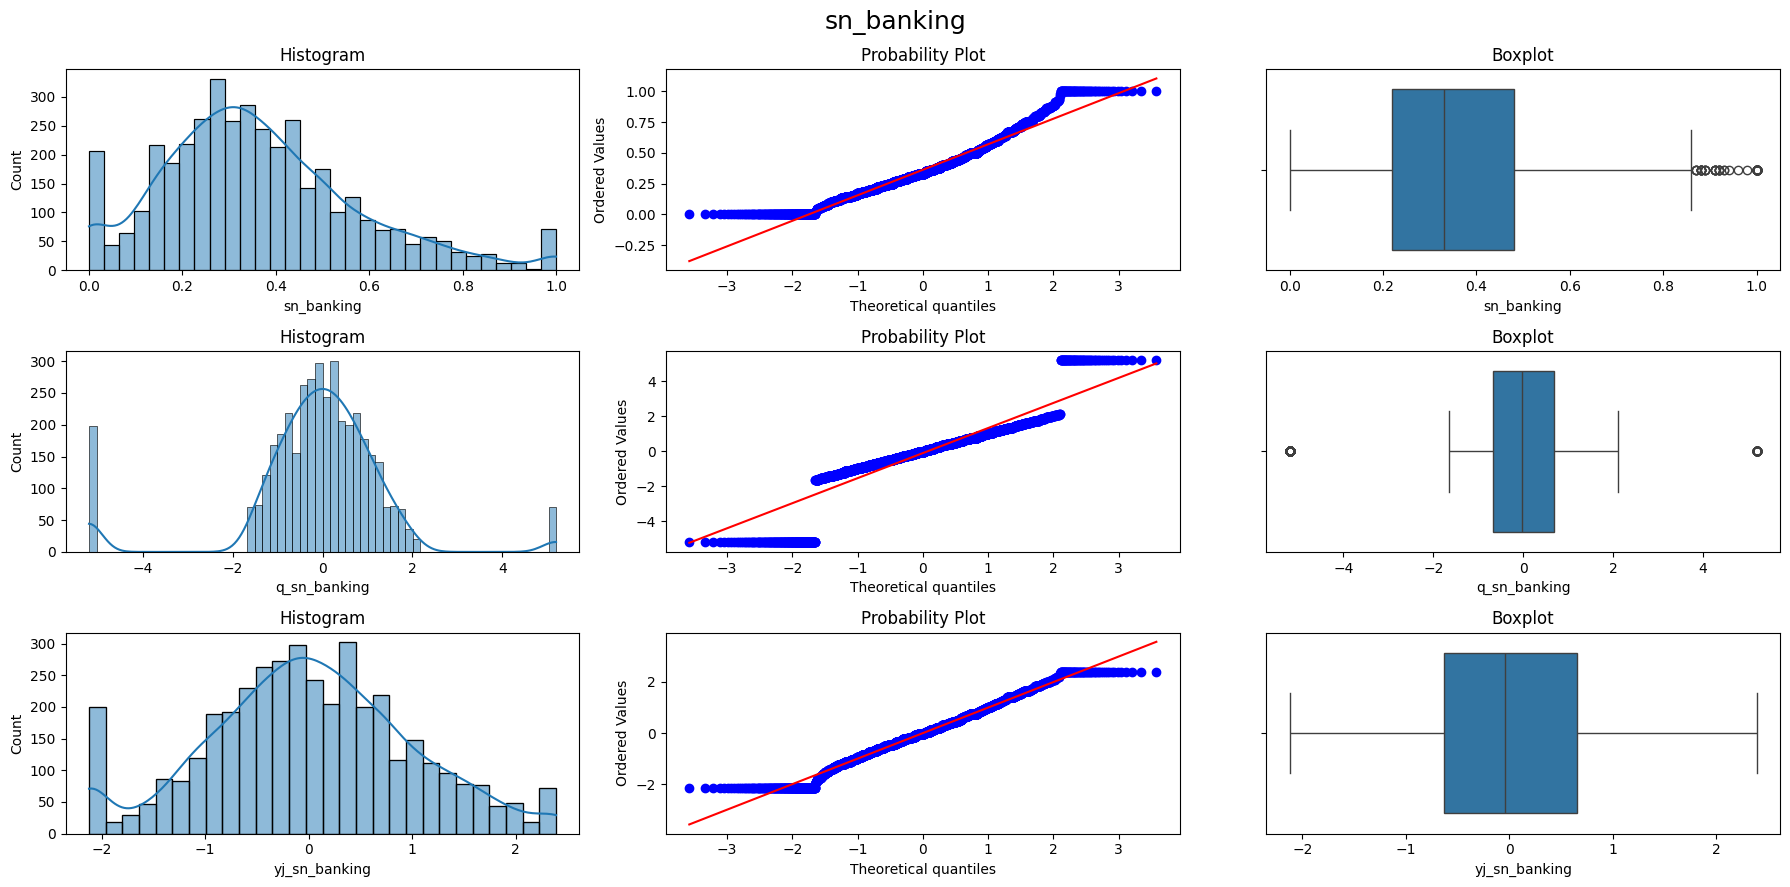

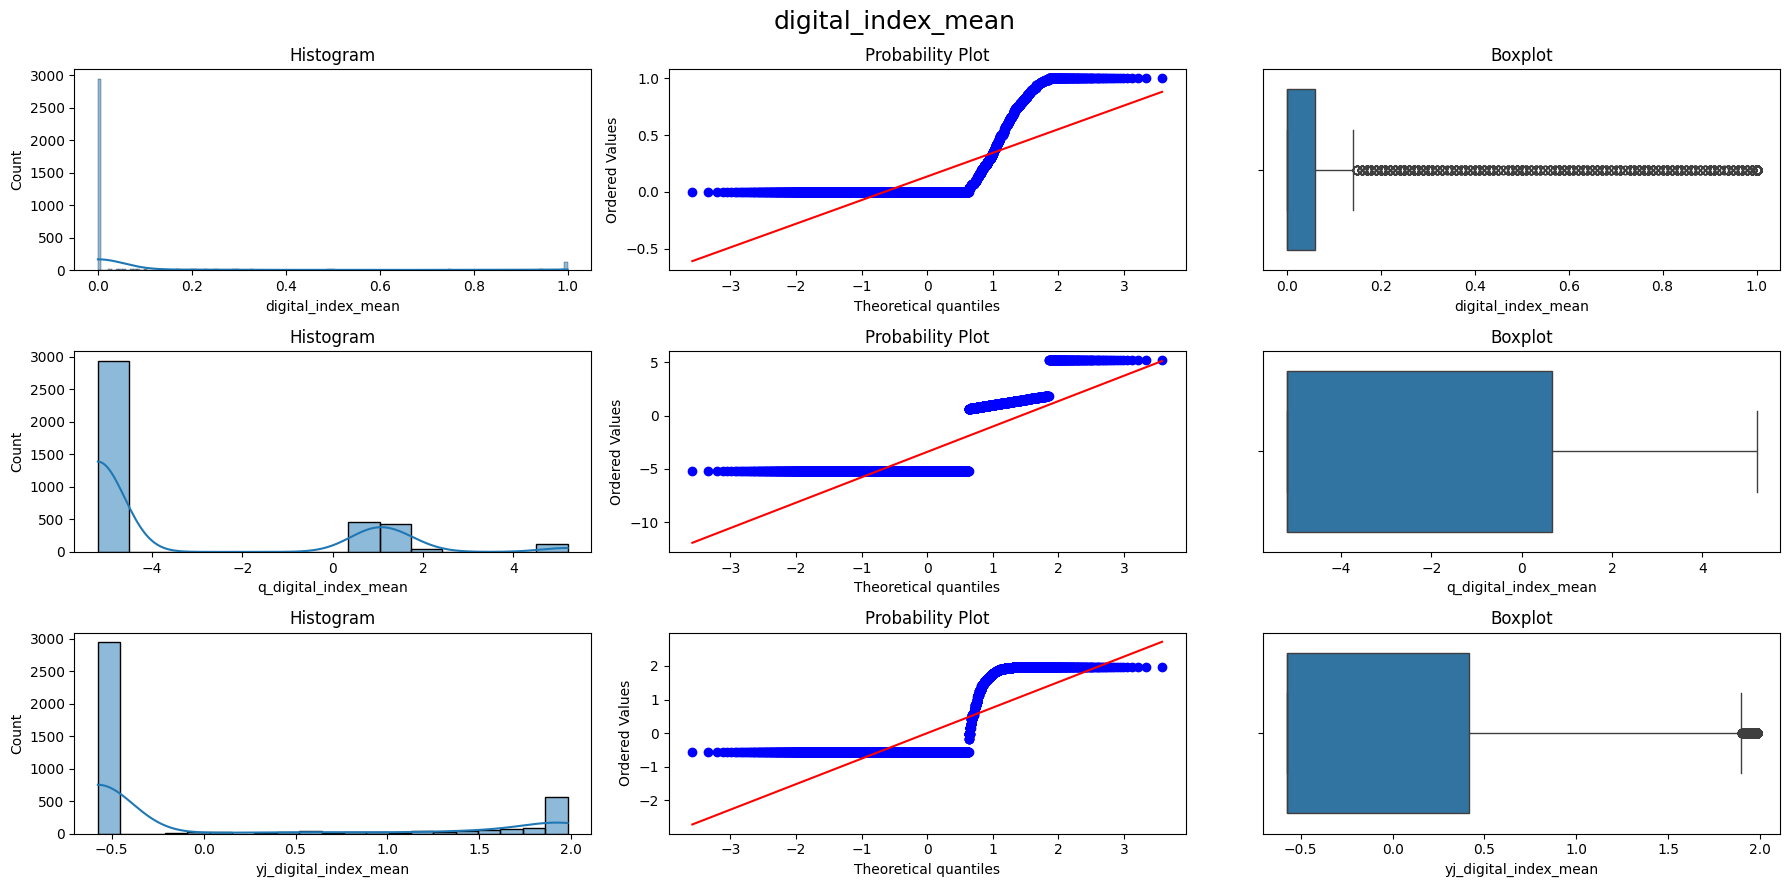

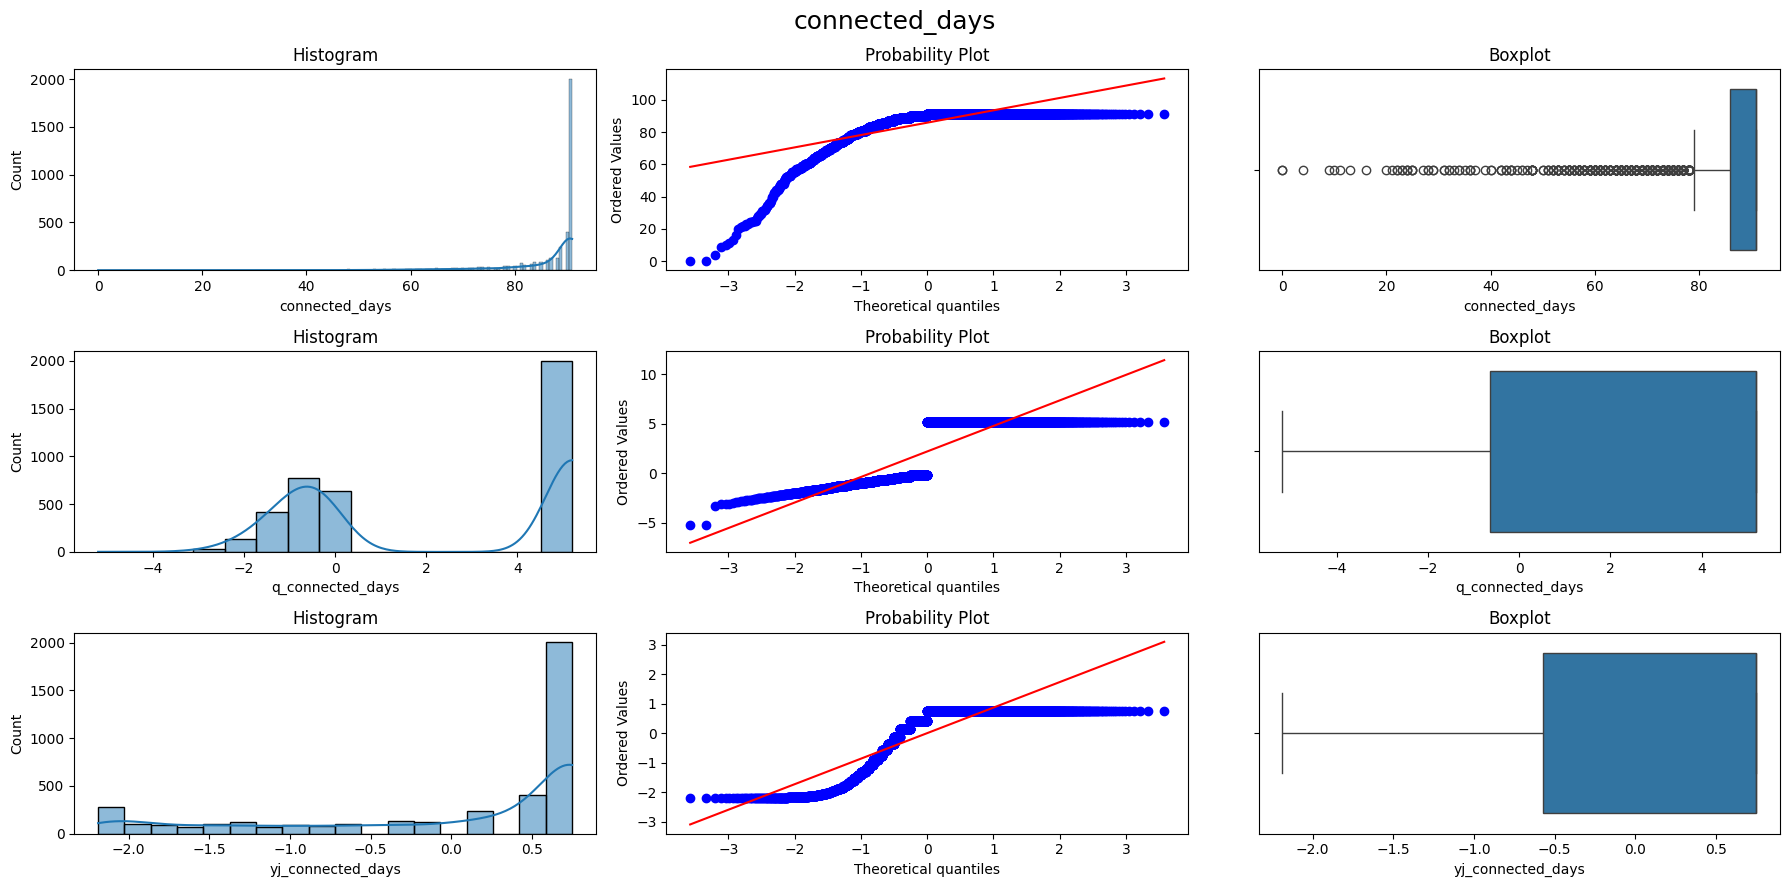

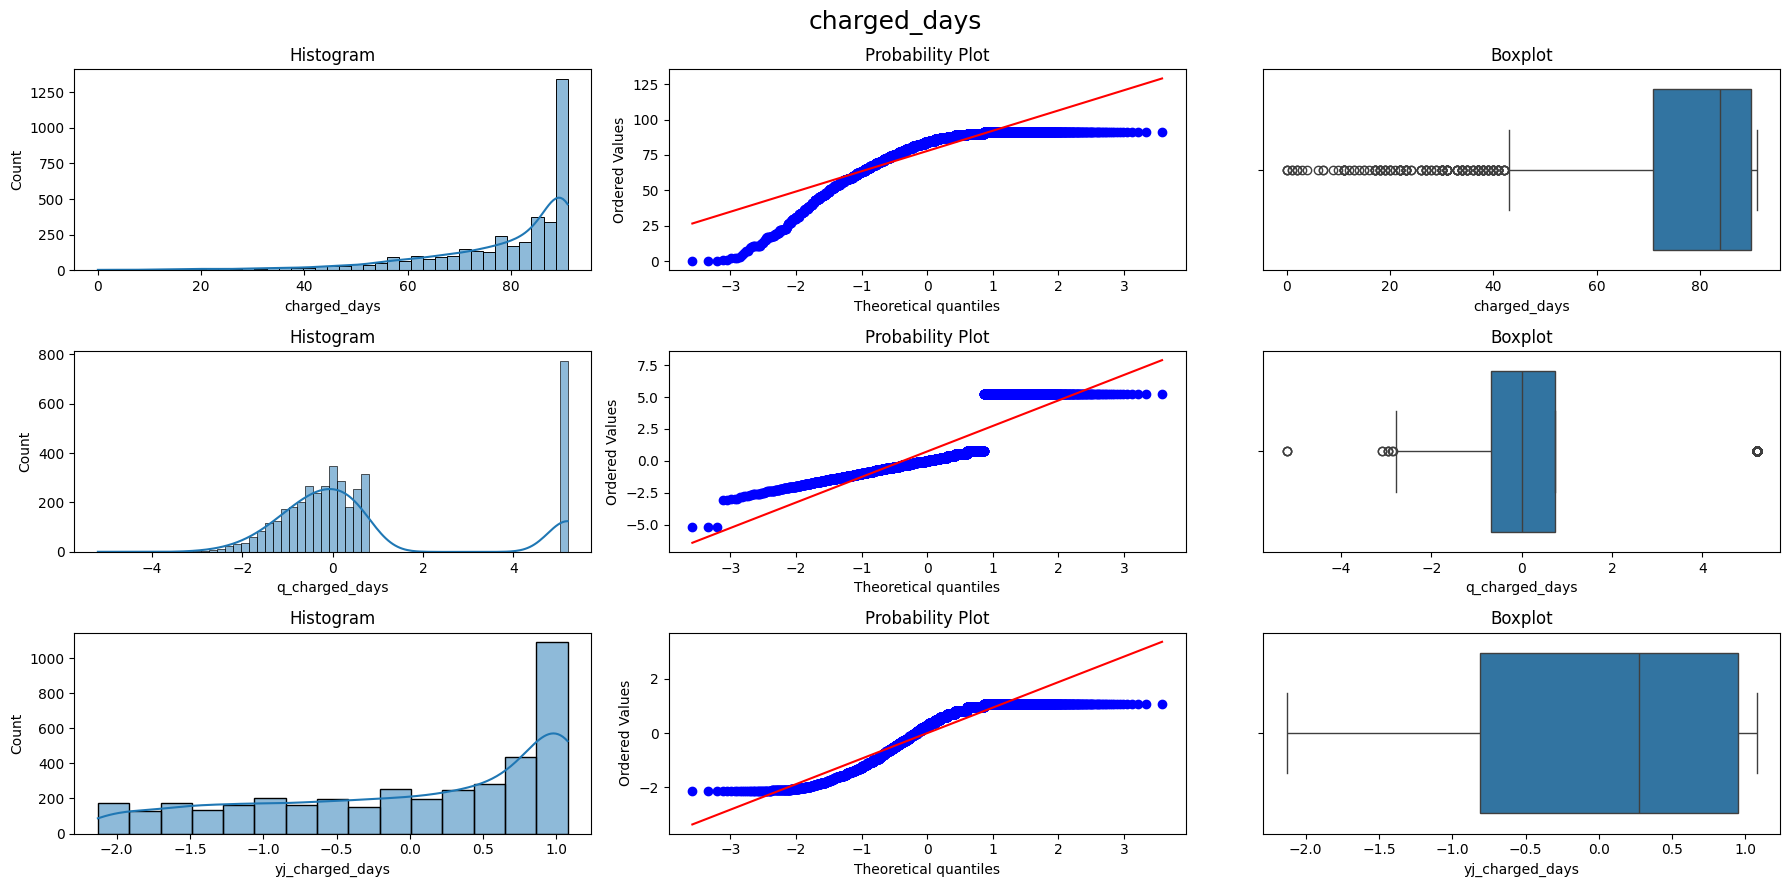

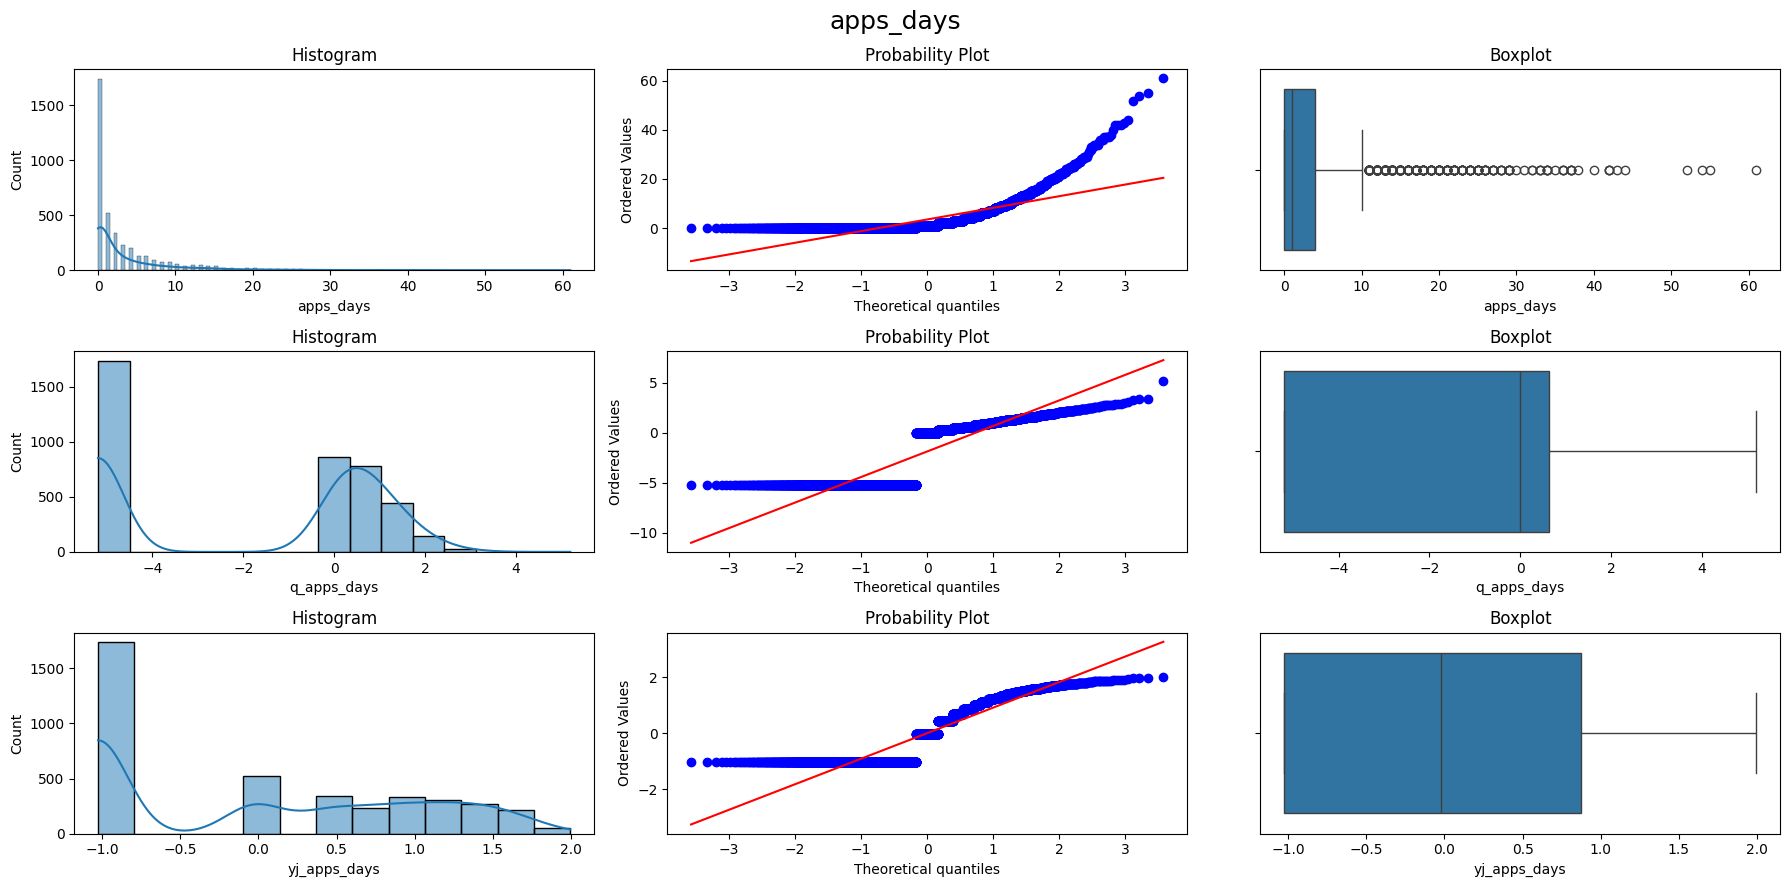

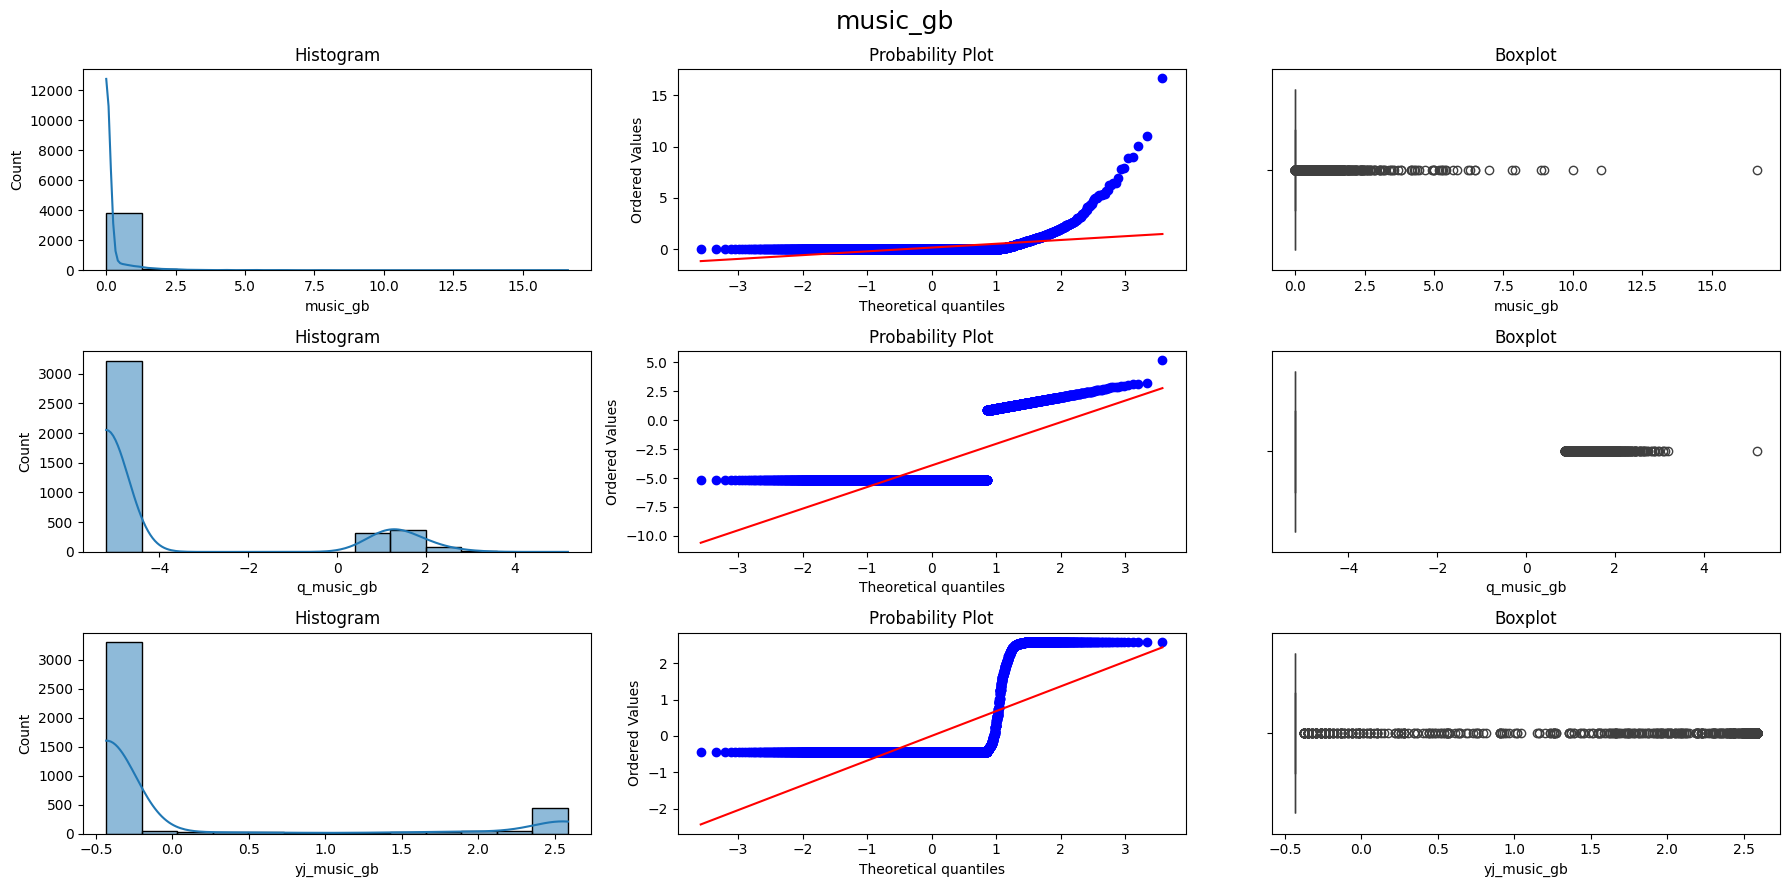

In [44]:
df_train_sample = df_train.sample(4000)

for col in df_train_sample.columns[2:len(df_train_sample.columns)-1]:
    plot_hist_prob(df_train_sample, col)

Using `plot_hist_prob`, the before/after panels show a consistent pattern: most numeric features (e.g., `previous_calls`, `network_age_years`, `arpu_90_days`, `minutes_in`, `start_using_months`, `contacts`) start highly right-skewed with long tails and many outliers; the **QuantileTransformer→normal** version yields the straightest QQ lines, bell-shaped histograms, and compressed whiskers—i.e., variance stabilized and extremes tamed. Overall, the transformed views indicate cleaner, near-Gaussian feature shapes with fewer leverage points, which aligns with the behavior seen across all plotted columns.



## Resampling

In [45]:
train_X, train_y = df_split(df_train)
test_X, test_y = df_split(df_test)

In [46]:
train_X_resampled, train_y_resampled = under_sampling(train_X, train_y, ratio=0.85)

Revisar cómo quedó el remuestreo en el balance de las clases

In [47]:
train_y.mean()

0.03736728968898838

In [48]:
train_y_resampled.mean()

0.45946101577795695

Revisar el tamaño del dataset de entrenamiento

In [49]:
train_X.shape

(427058, 20)

In [50]:
train_X_resampled.shape

(34732, 20)

# Data Pipeline

* Cleaning
* Training

In [51]:
train_X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34732 entries, 51020 to 426991
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   state_name               34732 non-null  object 
 1   previous_classification  34732 non-null  object 
 2   previous_calls           34732 non-null  int64  
 3   client_age               26720 non-null  float64
 4   network_age_years        34732 non-null  float64
 5   banking                  34732 non-null  int64  
 6   arpu_90_days             34732 non-null  float64
 7   minutes_in               34732 non-null  float64
 8   validity_average         34732 non-null  float64
 9   average_performance      34732 non-null  float64
 10  start_using_months       34729 non-null  float64
 11  contacts                 34732 non-null  int64  
 12  high_frequency_contacts  34732 non-null  float64
 13  plan_postpaid            34732 non-null  float64
 14  sn_banking            

In [52]:
model = XGBClassifier(max_depth = 2, random_state=123)
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Train transformation with all the data.

In [53]:
target_encoder_state = TargetEncoder()
target_encoder_state.fit(train_X['state_name'],train_y)

TargetEncoder(cols=['state_name'])

In [54]:
client_age_median = train_X['client_age'].median()
network_age_years_median = train_X['network_age_years'].median()
start_using_months_median = train_X['start_using_months'].median()

The previous cell calculates the median values for the columns `client_age`, `network_age_years`, and `start_using_months` from the training set. These medians are used for imputing missing values in the corresponding features during data preprocessing. Using the median helps reduce the impact of outliers and ensures that missing data is replaced with a representative value from the distribution, improving model robustness.

In [55]:
quantile_transform_features = ['client_age','network_age_years','arpu_90_days','minutes_in','validity_average','average_performance','contacts']

q_transformer = QuantileTransformer(output_distribution='normal')
q_transformer.fit(train_X[quantile_transform_features])

QuantileTransformer(output_distribution='normal')

The selected features in `quantile_transform_features` are numerical variables that may have skewed distributions or outliers, which can negatively impact model performance. Applying a `QuantileTransformer` with `output_distribution='normal'` transforms these features to follow a Gaussian-like distribution. This normalization helps stabilize variance, reduces the influence of outliers, and makes the data more suitable for many machine learning algorithms, leading to improved predictive accuracy and model robustness.

In [56]:
yj_transform_features = ['previous_calls','start_using_months','high_frequency_contacts','plan_postpaid','sn_banking','connected_days','charged_days','apps_days']

yj_transformer = PowerTransformer(method='yeo-johnson')
yj_transformer.fit(train_X[yj_transform_features])

PowerTransformer()

The previous cell fits a Yeo-Johnson power transformer on selected features from the training set. This transformation helps stabilize variance and make the data more Gaussian-like, which can improve the performance of many machine learning algorithms. By fitting the transformer only on the training data, we avoid data leakage and ensure that the transformation is consistent when applied to new data.

Definición del pipeline

In [57]:
model_pipeline = Pipeline(steps=[
    # state_name: Target Encoder
    #('state_name_target_encoder', ExperimentalTransformer('state_name', 'apply_target_encoder'))
    ('state_name_target_encoder', ExperimentalTransformer('state_name', 'use_target_encoder', {'encoder':target_encoder_state}))
    # previous_classification: One Hot Encoder
    , ('previous_classification_one_hot_encoder', ExperimentalTransformer('previous_classification', 'apply_one_hot_encoder'))
    # client_age: set_nan_value fuera de 18-80, imputar con mediana
    , ('client_age_set_nan', ExperimentalTransformer('client_age', 'set_nan_value', {'min': 18, 'max': 80}))
    #, ('client_age_impute_nan', ExperimentalTransformer('client_age', 'impute_nan', {'metric': 'median', 'specific_value': None}))
    , ('client_age_impute_nan', ExperimentalTransformer('client_age', 'impute_nan', {'metric': 'specific', 'specific_value': client_age_median}))
    # network_age_years: imputar con mediana
    #, ('network_age_years_impute_nan', ExperimentalTransformer('network_age_years', 'impute_nan', {'metric': 'median', 'specific_value': None}))
    , ('network_age_years_impute_nan', ExperimentalTransformer('network_age_years', 'impute_nan', {'metric': 'specific', 'specific_value': network_age_years_median}))
    # minutes_in: truncar en 300
    , ('minutes_in_truncate', ExperimentalTransformer('minutes_in', 'column_truncate', {'upper_bound': 300, 'value': 300}))
    # average_performance: truncar en 1
    , ('average_performance_truncate', ExperimentalTransformer('average_performance', 'column_truncate', {'upper_bound': 1, 'value': 1}))
    # start_using_months: set_nan_value fuera de 0-94, imputar con mediana
    , ('start_using_months_set_nan', ExperimentalTransformer('start_using_months', 'set_nan_value', {'min': 0, 'max': 94}))
    #, ('start_using_months_impute_nan', ExperimentalTransformer('start_using_months', 'impute_nan', {'metric': 'median', 'specific_value': None}))
    , ('start_using_months_impute_nan', ExperimentalTransformer('start_using_months', 'impute_nan', {'metric': 'specific', 'specific_value': start_using_months_median}))
    # previous_calls: ninguna accion
    # banking: ninguna accion
    # arpu_90_days: ninguna accion
    # validity_average: ninguna accion
    # contacts: ninguna accion
    # high_frequency_contacts: ninguna accion
    # plan_postpaid: ninguna accion
    # sn_banking: ninguna accion
    # digital_index_mean: ninguna accion
    # connected_days: ninguna accion
    # charged_days: ninguna accion
    # apps_days: ninguna accion
    # music_gb: ninguna accion
    , ('quantile_transformations', ExperimentalTransformer(quantile_transform_features, 'apply_transformer', {'transformer': q_transformer}))
    , ('yeo_johnson_transformations', ExperimentalTransformer(yj_transform_features, 'apply_transformer', {'transformer': yj_transformer}))

    # debug
    , ("debug", Debug())

    # model
    , ('classifier', model)
])

In [58]:
result = model_pipeline.fit(X=train_X_resampled, y=train_y_resampled)

Doing fit on feature  state_name
Doing transform on feature  state_name
Doing fit on feature  previous_classification
Doing transform on feature  previous_classification
Doing fit on feature  client_age
Doing transform on feature  client_age
Doing transform on feature  client_age  | lower bound: 18  | upper bound: 80
Doing fit on feature  client_age
 The value on impute_nan is: 40.0
Doing transform on feature  client_age
 The value on impute_nan is: 40.0
Doing fit on feature  network_age_years
 The value on impute_nan is: 2.53
Doing transform on feature  network_age_years
 The value on impute_nan is: 2.53
Doing fit on feature  minutes_in
Doing transform on feature  minutes_in
Doing fit on feature  average_performance
Doing transform on feature  average_performance
Doing fit on feature  start_using_months
Doing transform on feature  start_using_months
Doing transform on feature  start_using_months  | lower bound: 0  | upper bound: 94
Doing fit on feature  start_using_months
 The value o

In [59]:
result

Pipeline(steps=[('state_name_target_encoder',
                 ExperimentalTransformer(feature_name='state_name',
                                         parameters={'encoder': TargetEncoder(cols=['state_name'])},
                                         transformation='use_target_encoder')),
                ('previous_classification_one_hot_encoder',
                 ExperimentalTransformer(feature_name='previous_classification',
                                         transformation='apply_one_hot_encoder')),
                ('client_age...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [60]:
train_X_transformed = pd.read_csv('x.csv')

In [61]:
train_X_transformed

state_name  previous_classification_NOT INTERESTED  \
0        0.044849                                       1   
1        0.032019                                       0   
2        0.042551                                       0   
3        0.032019                                       0   
4        0.040718                                       0   
...           ...                                     ...   
34727    0.044849                                       0   
34728    0.032019                                       0   
34729    0.042471                                       0   
34730    0.032019                                       1   
34731    0.032019                                       0   

       previous_classification_NEW CLIENT  \
0                                       0   
1                                       1   
2                                       1   
3                                       0   
4                                       0   
...                                   ...   
34727                                   0   
34728                                   0   
34729                                   1   
34730                                   0   
34731                                   1   

       previous_classification_NOT EFFECTIVE  previous_calls  client_age  \
0                                          0        0.756483    0.096753   
1                                          0       -1.146922    0.008782   
2                                          0       -1.146922    0.008782   
3                                          1        0.141891   -0.076604   
4                                          1        0.141891    1.439001   
...                                      ...             ...         ...   
34727                                      1        0.141891   -0.830234   
34728                                      1        0.141891    1.114032   
34729                                      0       -1.146922    0.008782   
34730                                      0        0.141891   -0.166367   
34731                                      0       -1.146922    1.654145   

       network_age_years  banking  arpu_90_days  minutes_in  ...  \
0              -0.650274        1      1.849432   -0.037144  ...   
1              -1.629992        0      1.991918    0.259707  ...   
2              -0.350817        1      3.171175    0.267603  ...   
3              -1.093272        0     -0.662724   -0.897143  ...   
4               0.718462        1     -0.816150   -0.387850  ...   
...                  ...      ...           ...         ...  ...   
34727          -0.124523        1     -0.602934    1.793897  ...   
34728           2.156821        1      1.112122    0.645325  ...   
34729          -1.046576        1     -0.608973    0.704353  ...   
34730          -0.111890        1     -0.557214   -1.765640  ...   
34731          -0.012546        1      2.563764   -1.181941  ...   

       start_using_months  contacts  high_frequency_contacts  plan_postpaid  \
0                0.027311 -0.172731                 1.284758      -1.414035   
1               -0.571819 -0.764710                -0.708361      -1.414035   
2                0.493837  0.630254                 1.122551      -0.705836   
3               -0.094003 -1.266860                 1.122551       0.220364   
4               -1.567259 -1.055293                -0.196601      -0.412416   
...                   ...       ...                      ...            ...   
34727            1.047643  0.374936                 0.723455       1.974538   
34728           -0.799323  0.967422                -1.407060      -0.811871   
34729           -1.100588  0.605955                -0.418195       0.286821   
34730            0.493837 -1.337127                 2.117625       0.880332   
34731            1.144406 -1.486537                -0.196601       0.923922   

       sn_banking  digital_index_mean  connected_days 

# Evaluate Train

In [62]:
train_y_predicted = result.predict_proba(train_X)[:,1]

Doing transform on feature  state_name
Doing transform on feature  previous_classification
Doing transform on feature  client_age
Doing transform on feature  client_age  | lower bound: 18  | upper bound: 80
Doing transform on feature  client_age
 The value on impute_nan is: 40.0
Doing transform on feature  network_age_years
 The value on impute_nan is: 2.53
Doing transform on feature  minutes_in
Doing transform on feature  average_performance
Doing transform on feature  start_using_months
Doing transform on feature  start_using_months  | lower bound: 0  | upper bound: 94
Doing transform on feature  start_using_months
 The value on impute_nan is: 7.0
Doing transform on feature  ['client_age', 'network_age_years', 'arpu_90_days', 'minutes_in', 'validity_average', 'average_performance', 'contacts']
Doing transform on feature  ['previous_calls', 'start_using_months', 'high_frequency_contacts', 'plan_postpaid', 'sn_banking', 'connected_days', 'charged_days', 'apps_days']
(427058, 22)


In [63]:
threshold_metrics = threshold_iter(train_y, train_y_predicted, min=0, max=1, step=0.05)
threshold_metrics_df = pd.DataFrame(threshold_metrics)
threshold_metrics_df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


threshold  positive_prediction  precision    recall        f1 support  \
0        0.00             1.000000   0.037367  1.000000  0.072043    None   
1        0.05             0.999916   0.037370  1.000000  0.072048    None   
2        0.10             0.998017   0.037432  0.999749  0.072162    None   
3        0.15             0.986592   0.037825  0.998684  0.072890    None   
4        0.20             0.948255   0.039048  0.990914  0.075136    None   
5        0.25             0.875879   0.041280  0.967602  0.079183    None   
6        0.30             0.774963   0.044517  0.923236  0.084938    None   
7        0.35             0.657894   0.048658  0.856686  0.092086    None   
8        0.40             0.533651   0.054006  0.771275  0.100944    None   
9        0.45             0.410869   0.060280  0.662802  0.110509    None   
10       0.50             0.297648   0.068183  0.543113  0.121157    None   
11       0.55             0.200369   0.077855  0.417471  0.131236    None   
12       0.60             0.123210   0.090691  0.299035  0.139174    None   
13       0.65             0.067761   0.104776  0.189999  0.135068    None   
14       0.70             0.032223   0.121212  0.104524  0.112251    None   
15       0.75             0.012418   0.139355  0.046309  0.069517    None   
16       0.80             0.003327   0.177340  0.015791  0.029001    None   
17       0.85             0.000482   0.199029  0.002569  0.005073    None   
18       0.90             0.000009   0.000000  0.000000  0.000000    None   
19       0.95             0.000000   0.000000  0.000000  0.000000    None   

        tn      fp     fn     tp  
0        0  411100      0  15958  
1       36  411064      0  15958  
2      843  410257      4  15954  
3     5705  405395     21  15937  
4    21953  389147    145  15813  
5    52490  358610    517  15441  
6    94879  316221   1225  14733  
7   143812  267288   2287  13671  
8   195508  215592   3650  12308  
9   246212  164888   5381  10577  
10  292654  118446   7291   8667  
11  332193   78907   9296   6662  
12  363254   47846  11186   4772  
13  385194   25906  12926   3032  
14  399007   12093  14290   1668  
15  406536    4564  15219    739  
16  409931    1169  15706    252  
17  410935     165  15917     41  
18  411096       4  15958      0  
19  411100       0  15958      0

# Evaluate Test

In [64]:
test_y_predicted = result.predict_proba(test_X)[:,1]

Doing transform on feature  state_name
Doing transform on feature  previous_classification
Doing transform on feature  client_age
Doing transform on feature  client_age  | lower bound: 18  | upper bound: 80
Doing transform on feature  client_age
 The value on impute_nan is: 40.0
Doing transform on feature  network_age_years
 The value on impute_nan is: 2.53
Doing transform on feature  minutes_in
Doing transform on feature  average_performance
Doing transform on feature  start_using_months
Doing transform on feature  start_using_months  | lower bound: 0  | upper bound: 94
Doing transform on feature  start_using_months
 The value on impute_nan is: 7.0
Doing transform on feature  ['client_age', 'network_age_years', 'arpu_90_days', 'minutes_in', 'validity_average', 'average_performance', 'contacts']
Doing transform on feature  ['previous_calls', 'start_using_months', 'high_frequency_contacts', 'plan_postpaid', 'sn_banking', 'connected_days', 'charged_days', 'apps_days']
(183025, 22)


In [65]:
test_y_predicted

array([0.73372734, 0.56656307, 0.34806222, ..., 0.3889642 , 0.38017857,
       0.37462988], dtype=float32)

array([[<Axes: title={'center': '0'}>]], dtype=object)

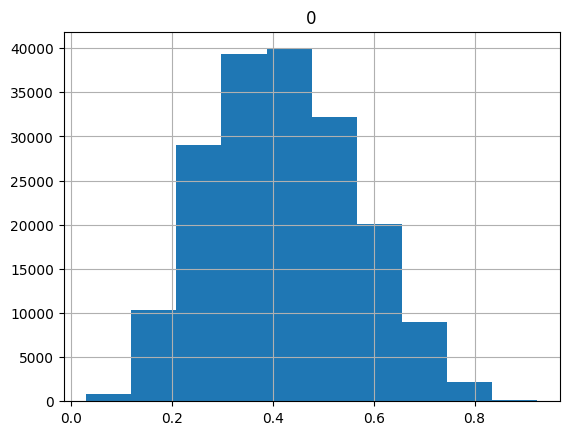

In [66]:
pd.DataFrame(test_y_predicted).hist()

In [67]:
test_X_transformed = pd.read_csv('x.csv')

In [68]:
test_X_transformed

state_name  previous_classification_NOT INTERESTED  \
0         0.044849                                       0   
1         0.041623                                       1   
2         0.046469                                       0   
3         0.043204                                       0   
4         0.029995                                       0   
...            ...                                     ...   
183020    0.044849                                       0   
183021    0.030993                                       0   
183022    0.041623                                       0   
183023    0.041623                                       1   
183024    0.034824                                       0   

        previous_classification_NEW CLIENT  \
0                                        1   
1                                        0   
2                                        1   
3                                        0   
4                                        1   
...                                    ...   
183020                                   1   
183021                                   1   
183022                                   0   
183023                                   0   
183024                                   0   

        previous_classification_NOT EFFECTIVE  previous_calls  client_age  \
0                                           0       -1.146922   -1.169401   
1                                           0        0.756483    0.336178   
2                                           0       -1.146922   -0.076604   
3                                           1        0.141891   -0.076604   
4                                           0       -1.146922    1.242061   
...                                       ...             ...         ...   
183020                                      0       -1.146922    0.096753   
183021                                      0       -1.146922   -0.254902   
183022                                      1        0.141891    1.310017   
183023                                      0        1.410797    0.008782   
183024                                      1        0.756483   -0.830234   

        network_age_years  banking  arpu_90_days  minutes_in  ...  \
0                0.417002        1      1.855346   -0.203672  ...   
1                1.627576        1     -0.552537   -0.785877  ...   
2                0.123259        1     -0.412820   -1.740890  ...   
3                1.672316        1     -1.921082    1.020645  ...   
4                1.452943        0     -1.093627   -1.505163  ...   
...                   ...      ...           ...         ...  ...   
183020          -1.189522        0     -0.644924    1.673776  ...   
183021          -0.601439        1      0.657088   -1.050606  ...   
183022          -0.565738        0      0.898334    1.793897  ...   
183023          -0.176553        1      1.031776   -0.155810  ...   
183024           0.086674        0      0.102630    1.793897  ...   

        start_using_months  contacts  high_frequency_contacts  plan_postpaid  \
0                -0.799323 -1.851734                 0.802538       1.869874   
1                 0.568708  1.114032                -0.851165       0.529697   
2                -1.567259  0.072829                 0.410817       0.638714   
3                -0.571819  0.630254                -0.046990       0.079803   
4                -0.094003 -0.933910                -1.270395      -1.414035   
...                    ...       ...                      ...            ...   
183020           -0.799323 -0.713599                 0.104119       0.690421   
183021            0.639315 -0.418371                -0.708361      -1.414035   
183022           -0.799323 -0.211070                -0.121983      -0.604052   
183023            0.236667  1.020888                -0.344707      -0.922378   
183024           -0.571819  0.374936                 0.028378      -0.922378

In [69]:
threshold_metrics = threshold_iter(test_y, test_y_predicted, min=0, max=1, step=0.05)
threshold_metrics_df = pd.DataFrame(threshold_metrics)
threshold_metrics_df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


threshold  positive_prediction  precision    recall        f1 support  \
0        0.00             1.000000   0.037798  1.000000  0.072843    None   
1        0.05             0.999934   0.037801  1.000000  0.072848    None   
2        0.10             0.998252   0.037848  0.999566  0.072934    None   
3        0.15             0.986701   0.038219  0.997687  0.073618    None   
4        0.20             0.948340   0.039321  0.986557  0.075628    None   
5        0.25             0.877246   0.041399  0.960827  0.079379    None   
6        0.30             0.775790   0.044567  0.914715  0.084993    None   
7        0.35             0.659325   0.048644  0.848511  0.092013    None   
8        0.40             0.533943   0.053794  0.759902  0.100475    None   
9        0.45             0.410403   0.059496  0.645996  0.108957    None   
10       0.50             0.297369   0.066843  0.525875  0.118610    None   
11       0.55             0.199541   0.074943  0.395635  0.126016    None   
12       0.60             0.121448   0.084038  0.270020  0.128182    None   
13       0.65             0.066882   0.096642  0.171003  0.123493    None   
14       0.70             0.031881   0.106255  0.089621  0.097232    None   
15       0.75             0.011911   0.125229  0.039462  0.060013    None   
16       0.80             0.003311   0.161716  0.014166  0.026050    None   
17       0.85             0.000568   0.230769  0.003469  0.006836    None   
18       0.90             0.000022   0.250000  0.000145  0.000289    None   
19       0.95             0.000000   0.000000  0.000000  0.000000    None   

        tn      fp    fn    tp  
0        0  176107     0  6918  
1       12  176095     0  6918  
2      317  175790     3  6915  
3     2418  173689    16  6902  
4     9362  166745    93  6825  
5    22196  153911   271  6647  
6    40446  135661   590  6328  
7    61304  114803  1048  5870  
8    83639   92468  1661  5257  
9   105462   70645  2449  4469  
10  125319   50788  3280  3638  
11  142323   33784  4181  2737  
12  155747   20360  5050  1868  
13  165049   11058  5735  1183  
14  170892    5215  6298   620  
15  174200    1907  6645   273  
16  175599     508  6820    98  
17  176027      80  6894    24  
18  176104       3  6917     1  
19  176107       0  6918     0

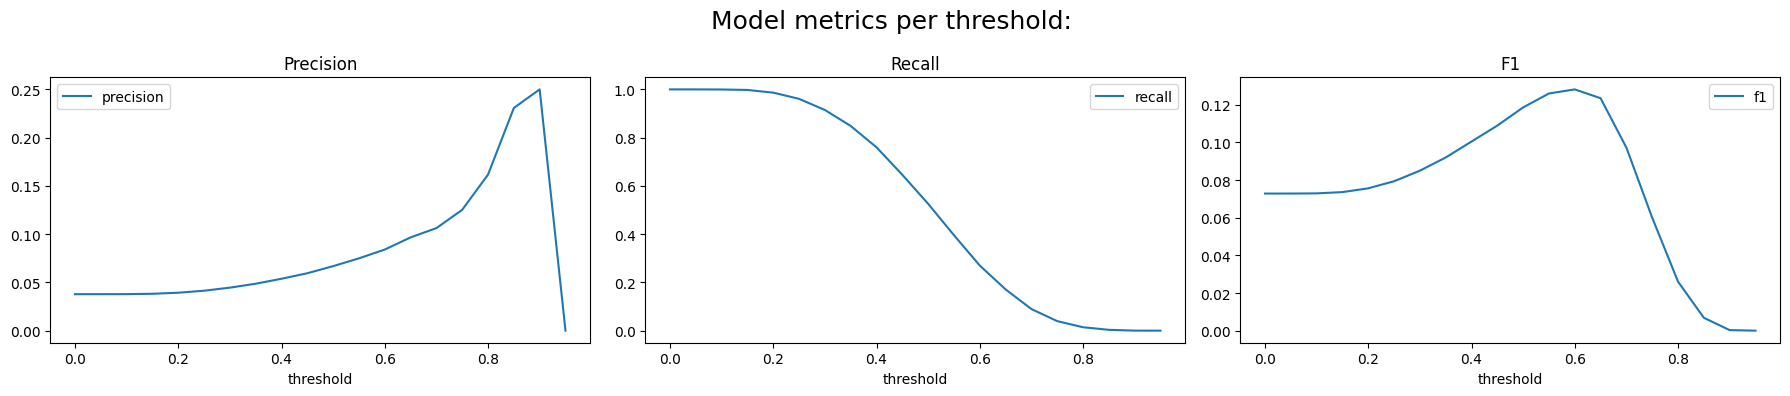

In [70]:
plot_threshold_metrics(threshold_metrics_df)

# Model Explainability

SHAP (SHapley Additive exPlanations) values are a method for interpreting machine learning model predictions. They quantify the contribution of each feature to the prediction for a specific sample, based on concepts from cooperative game theory.

- **Global Interpretability**: SHAP values can be aggregated across the dataset to show which features are most influential overall.
- **Local Interpretability**: For individual predictions, SHAP values explain how each feature impacted the model’s output.
- **Visualization**: Common plots include summary plots (showing feature importance and impact) and bar plots (ranking features by average absolute SHAP value).

In this notebook, SHAP values are computed for the test set using the trained model. The resulting plots help you understand which features drive predictions, supporting model transparency and trust.

In [71]:
shap_values_sel_model = evaluate_shap_values(
    model=model,
    X_test=test_X_transformed.sample(5000),
    plot=False)

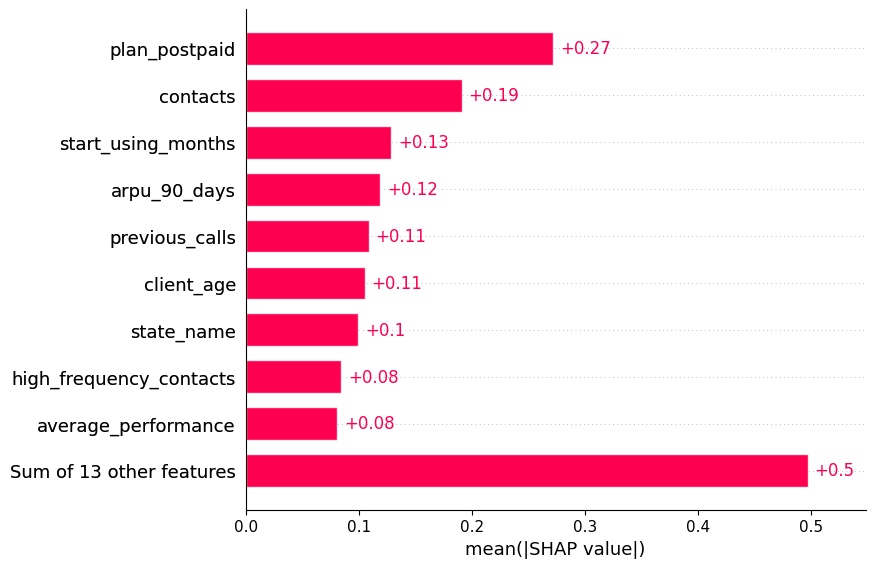

In [72]:
shap.plots.bar(shap_values_sel_model)

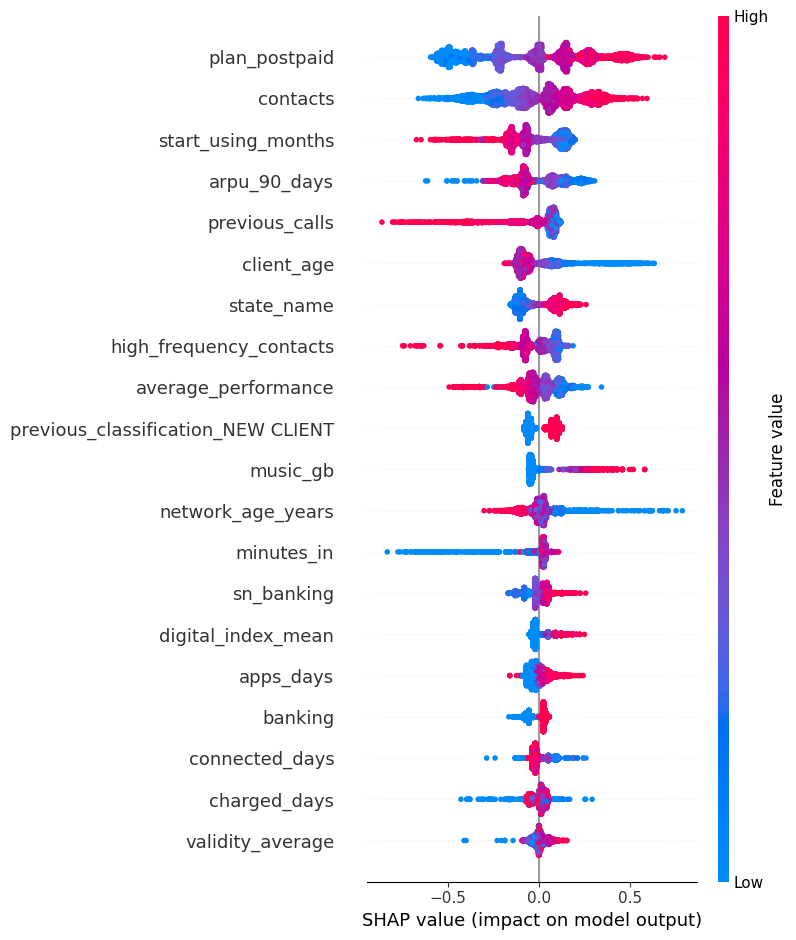

In [73]:
shap.summary_plot(shap_values_sel_model)

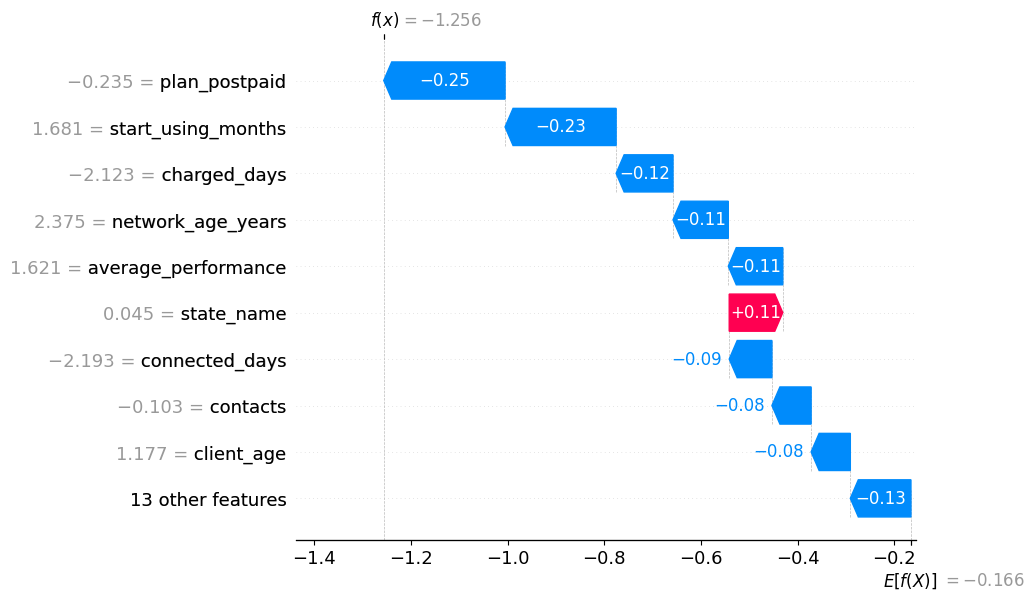

In [74]:
shap.plots.waterfall(shap_values_sel_model[0])

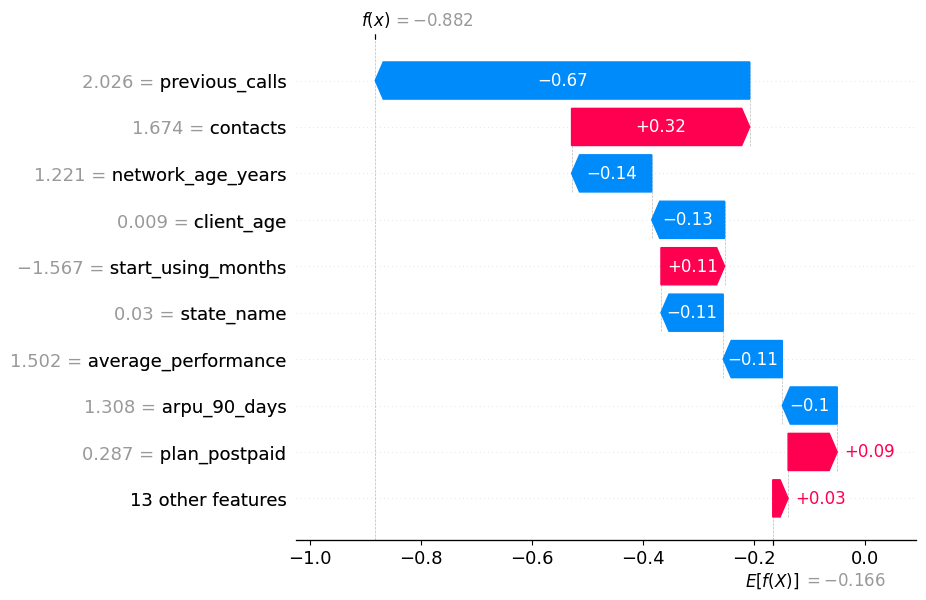

In [75]:
shap.plots.waterfall(shap_values_sel_model[1])

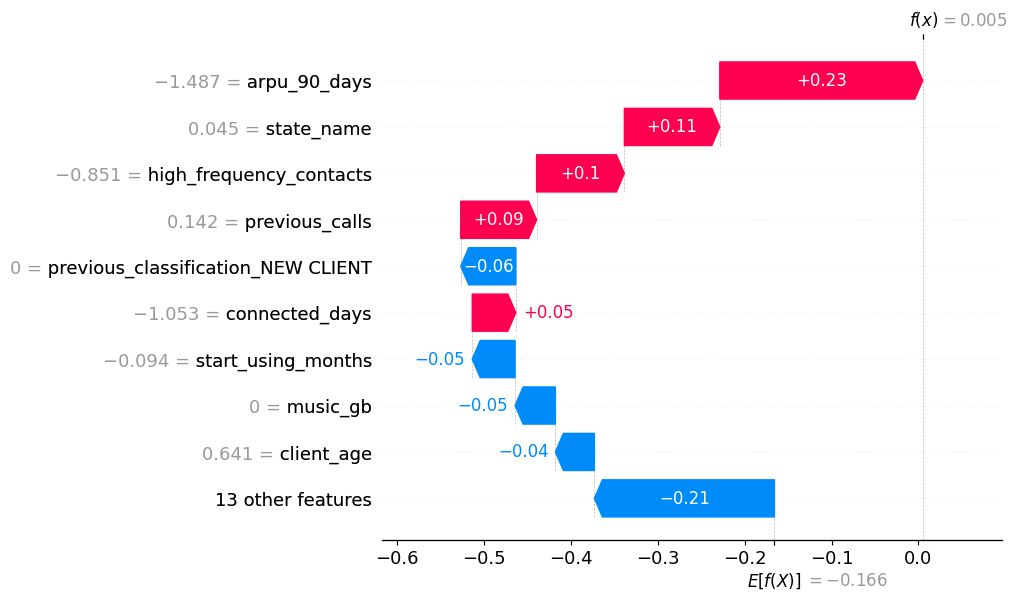

In [76]:
shap.plots.waterfall(shap_values_sel_model[2])

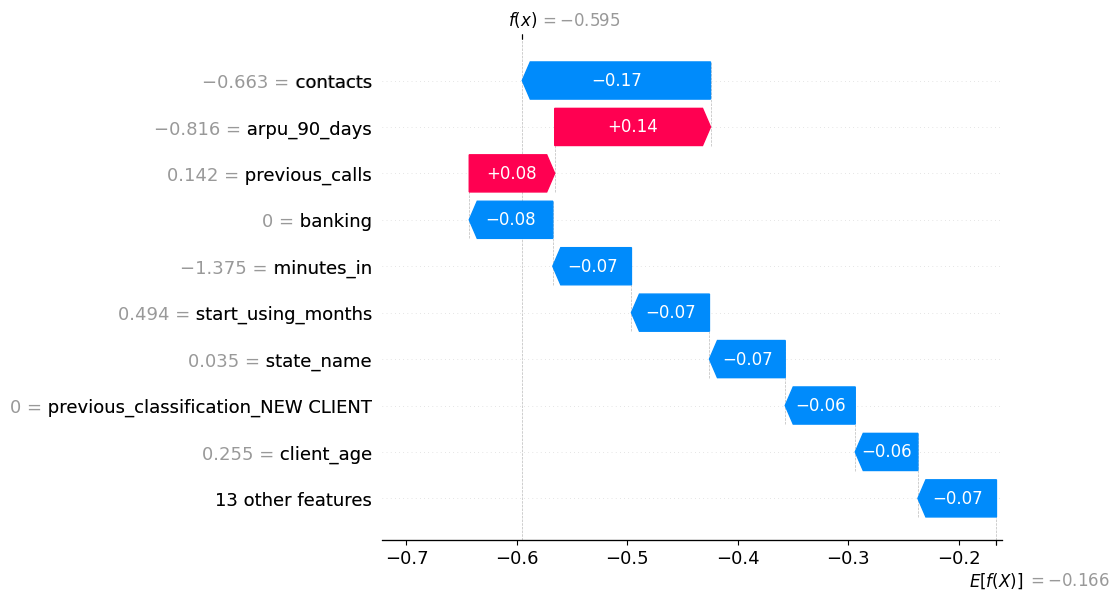

In [77]:
shap.plots.waterfall(shap_values_sel_model[3])

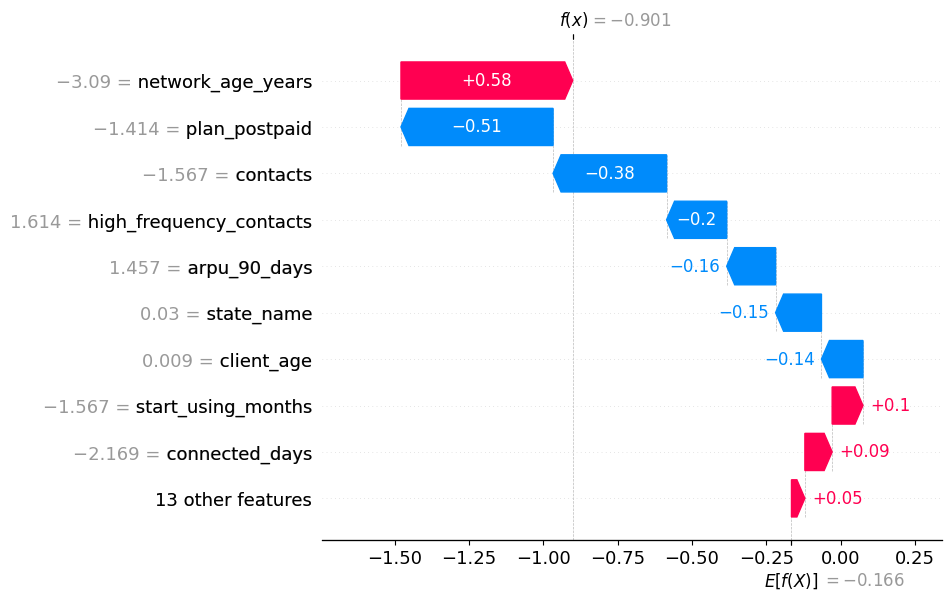

In [78]:
shap.plots.waterfall(shap_values_sel_model[4])

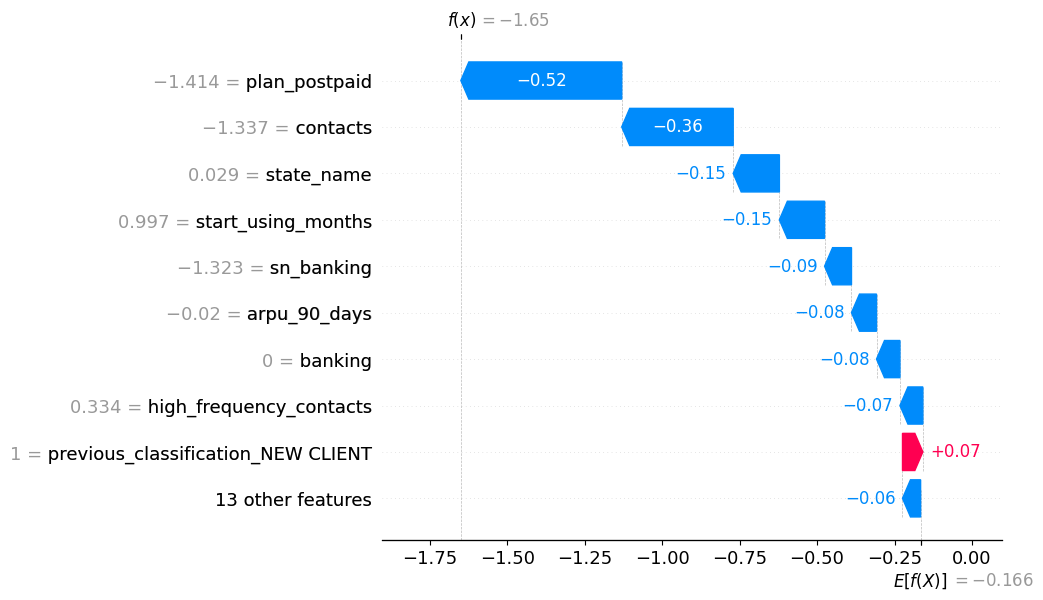

In [79]:
shap.plots.waterfall(shap_values_sel_model[5])

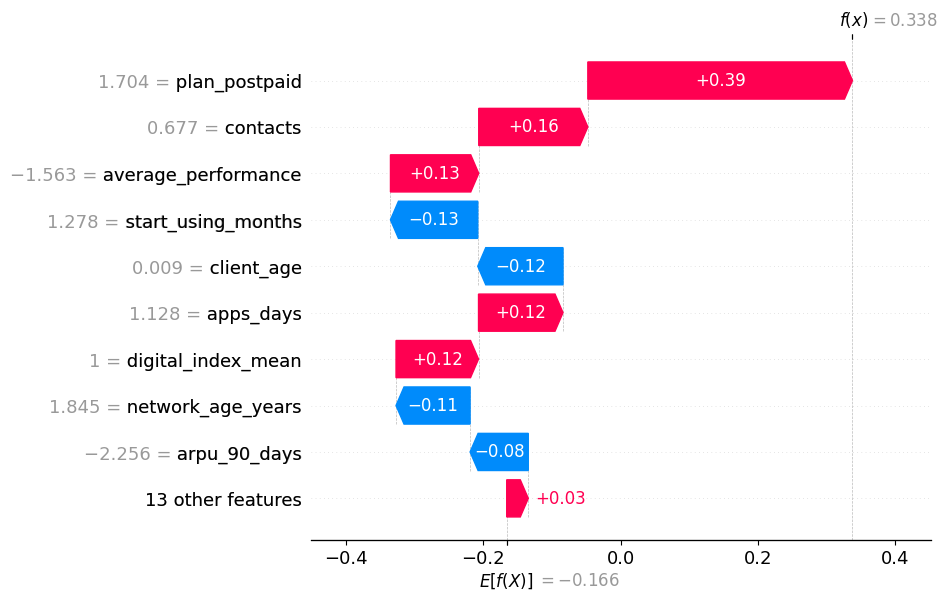

In [80]:
shap.plots.waterfall(shap_values_sel_model[6])

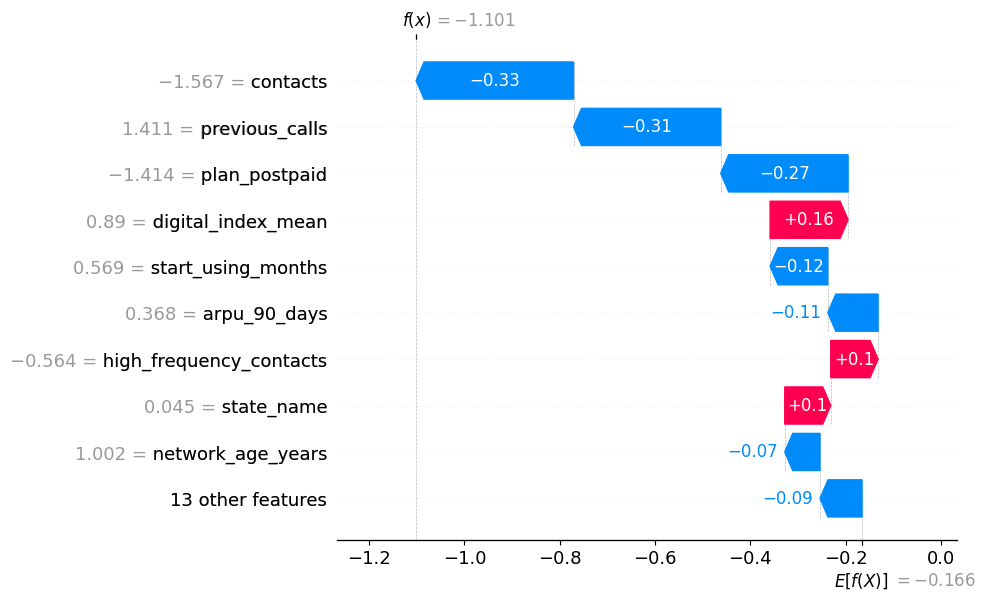

In [81]:
shap.plots.waterfall(shap_values_sel_model[7])

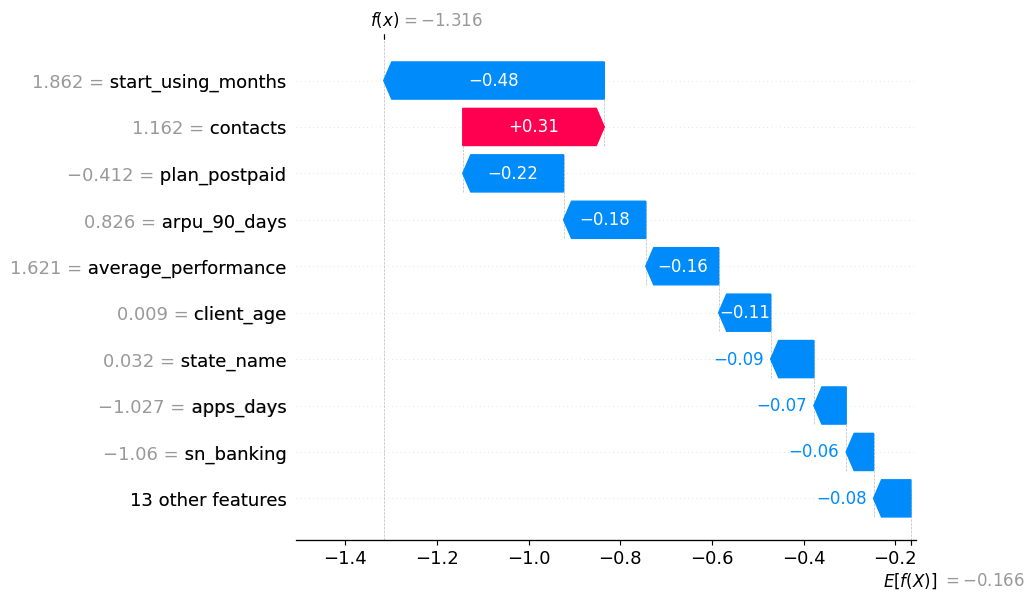

In [82]:
shap.plots.waterfall(shap_values_sel_model[8])

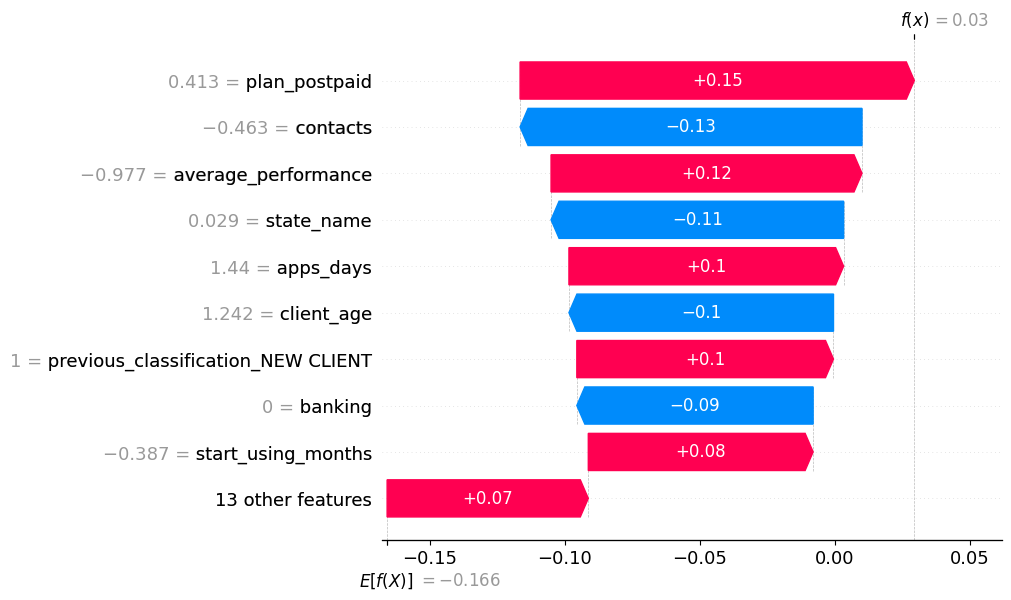

In [83]:
shap.plots.waterfall(shap_values_sel_model[9])

### Conclusions of the Data Preparation Phase (CRISP-ML)

The data preparation phase is fundamental in the CRISP-ML methodology, as it determines the quality and relevance of the information used for modeling. In this project, the following key actions were performed:

- **Feature selection**: The most relevant variables were identified and selected, removing those that were highly correlated, irrelevant, or had a high percentage of missing values. This reduces complexity and improves model interpretability.
- **Feature engineering**: New variables were created and transformed from existing ones to capture additional information and enhance the model's predictive power. This stage included combining variables, generating indicators, and transforming formats to facilitate algorithm learning.
    - Categorical and numerical variables were analyzed, generating indicators such as average sales per category and frequency of cardinal values.
    - Specific transformations were applied, such as truncating extreme values in critical variables (e.g., minutes_in and average_performance) and creating derived variables like proportions and means.
    - Advanced encoding techniques were used, such as Target Encoding for high-cardinality variables and One Hot Encoding for variables with few categories.
- **Handling missing values**: Missing values were imputed using the median for numerical variables, minimizing the impact of outliers and ensuring dataset robustness. Percentages of missing values per variable were identified and documented.
- **Categorical variable encoding**: Techniques like Target Encoding and One Hot Encoding were applied to transform categorical variables into suitable numerical representations for machine learning algorithms.
- **Normalization and transformation**: Transformations such as Quantile Transformer and Yeo-Johnson were used to stabilize variance and approximate the distribution of numerical variables to a more suitable form for modeling.
    - Specific variables were selected for each type of transformation, ensuring more Gaussian-like distributions and reducing the effect of outliers.
- **Outlier handling**: Extreme values in critical variables were truncated to prevent them from negatively impacting model performance. Boxplots were used to identify and visualize outliers in numerical variables.
- **Class balancing**: Resampling techniques were applied to balance the class proportions in the training set, improving predictive capacity and model generalization.
- **Data splitting**: A stratified split was performed into training and test sets, ensuring the representativeness of both classes and proper model evaluation.
- **Transformation pipeline**: A modular pipeline was defined that integrates all stages of cleaning, transformation, and modeling, enabling reproducibility and traceability throughout the process.

These actions ensure that the data is clean, structured, and ready for the modeling phase, aligning with CRISP-ML principles and facilitating reliable and reproducible results.